In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt
import math
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

2022-06-01 23:05:10.764867: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-01 23:05:11.773076: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-01 23:05:11.773694: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-01 23:05:11.817565: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 23:05:11.817708: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.2GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2022-06-01 23:05:11.817724: I tensorflow/stream_executor/platform/defa

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [2]:
def build_generator(inputs, image_size):
    
    image_resize = image_size // 4
    # network parameters
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]
    
    x = Dense(image_resize * image_resize * layer_filters[0])(inputs)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)
    
    for filters in layer_filters:
        # First two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Conv2DTranspose(filters=filters,
                           kernel_size=kernel_size,
                           strides=strides,
                           padding='same')(x)
        
    tx = Activation('sigmoid')(x)
    generator = Model(inputs, x, name='generator')
    
    return generator

def build_discriminator(inputs):
    
    kernel_size = 5
    layer_filters  = [32, 64, 128, 256]
    
    x = inputs
    for filters in layer_filters:
        #first 3 convolution layers use stride = 2
        #last one uses stride = 1
        if filters == layer_filters[-1]:
            strides = 1
        
        else:
            strides = 2
        
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same')(x)
    
    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model(inputs, x, name='discriminator')
    
    return discriminator

def build_and_train_models():
    # Load MNIST dataset
    (x_train, _), (_, _) = mnist.load_data()
    
    # Reshape data for CNN as (28, 28, 1) and normalise
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32')/255
    
    model_name = 'dc_glash'
    # Network parameters
    # the latent or z vector is 100-dim
    latent_size = 100
    batch_size = 64
    train_steps = 10000
    lr = 2e-4
    decay = 6e-8
    input_shape = (image_size, image_size, 1)
    
    # Build discriminator model
    inputs = Input(shape=input_shape, name='discriminator_input')
    discriminator = build_discriminator(inputs)
    
    # Original paper uses Adam, but the discrinator converges easily with RMSprop
    optimizer = RMSprop(lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                         optimizer=optimizer,
                         metrics=['accuracy'])
    discriminator.summary()
    
    # Build generator model
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, image_size)
    generator.summary()
    
    # Build adversarial model
    optimizer = RMSprop(lr=lr * 0.5, decay=decay * 0.5)
    # Freeze the weights of discriminator during adversarial training
    discriminator.trainable = False
    # adversarial = generator + discriminator
    adversarial = Model(inputs,
                       discriminator(generator(inputs)),
                       name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy'])
    adversarial.summary()
    
    # train discriminator
    models = (generator, discriminator, adversarial)
    params = (batch_size, latent_size, train_steps, model_name)
    train(models, x_train, params)
    
def train(models, x_train, params):
    

    # The GAN component models
    generator, discriminator, adversarial = models
    # network parameters
    batch_size, latent_size, train_steps, model_name = params
    # the generator image is saved every 500 steps
    save_interval = 500
    # noise vector to see how the generator output evolves during training
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    
    # number of elements in train dataset
    train_size = x_train.shape[0]
    for i in range(train_steps):
        # train the discriminator for 1 batch
        # 1 batch of real (label=1) and fake images (label=0)
        # randomly pick real images from dataset
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        
        # generate fake images from noise using generator
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        
        # generate fake images
        fake_images = generator.predict(noise)
        # real + fake images = 1 batch of train data
        x = np.concatenate((real_images, fake_images))
        # label real images is 1
        y = np.ones([2 * batch_size, 1])
        # fake images label is 0
        y[batch_size:, :] = 0 
        # train discriminator network, log the loss and accuracy
        loss, acc = discriminator.train_on_batch(x, y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)
        
        # train the adversarial network for 1 batch
        # since the discriminator weights are frozen in adversarial network only the generator is trained
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        
        y = np.ones([batch_size, 1])
        # train the adversarial network
        loss, acc = adversarial.train_on_batch(noise, y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        print(log)
        
        if (i + 1) % save_interval == 0:
            # plot generator images on a periodic basis
            plot_images(generator,
                       noise_input=noise_input,
                       show=False,
                       step=(i + 1),
                       model_name=model_name)
        
        # save the model after training the generator
        # the trained generator can be reloaded for future MNIST digit generatio
        generator.save(model_name + ".h5")

def plot_images(generator,
                noise_input,
                show=False,
                step=0,
                model_name="gan"):
    """Generate fake images and plot them
    For visualization purposes, generate fake images
    then plot them in a square grid
    Arguments:
        generator (Model): The Generator Model for 
            fake images generation
        noise_input (ndarray): Array of z-vectors
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name
    """
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict(noise_input)
    plt.figure(figsize=(2.2, 2.2))
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')

build_and_train_models()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 28, 28, 1)]       0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)       

2022-03-28 19:38:21.254251: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-28 19:38:21.321276: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz
2022-03-28 19:38:21.853042: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-28 19:38:23.912775: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-03-28 19:38:30.304983: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-03-28 19:38:30.329860: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


0: [discriminator loss: 0.688809, acc: 0.859375] [adversarial loss: 0.860336, acc: 0.000000]
1: [discriminator loss: 0.607143, acc: 1.000000] [adversarial loss: 0.900830, acc: 0.000000]
2: [discriminator loss: 0.484169, acc: 1.000000] [adversarial loss: 0.597696, acc: 1.000000]
3: [discriminator loss: 0.316268, acc: 1.000000] [adversarial loss: 0.395138, acc: 1.000000]
4: [discriminator loss: 0.175449, acc: 1.000000] [adversarial loss: 0.008928, acc: 1.000000]
5: [discriminator loss: 0.178739, acc: 1.000000] [adversarial loss: 1.541788, acc: 0.000000]
6: [discriminator loss: 0.205043, acc: 0.960938] [adversarial loss: 0.031039, acc: 1.000000]
7: [discriminator loss: 0.042828, acc: 1.000000] [adversarial loss: 0.015282, acc: 1.000000]
8: [discriminator loss: 0.029871, acc: 1.000000] [adversarial loss: 0.009565, acc: 1.000000]
9: [discriminator loss: 0.026012, acc: 1.000000] [adversarial loss: 0.005239, acc: 1.000000]
10: [discriminator loss: 0.021113, acc: 1.000000] [adversarial loss: 0

88: [discriminator loss: 0.000028, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
89: [discriminator loss: 0.000022, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
90: [discriminator loss: 0.000026, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
91: [discriminator loss: 0.000023, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
92: [discriminator loss: 0.000019, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
93: [discriminator loss: 0.000015, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
94: [discriminator loss: 0.000016, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
95: [discriminator loss: 0.000013, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
96: [discriminator loss: 0.000014, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
97: [discriminator loss: 0.000014, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
98: [discriminator loss: 0.000015, acc: 1.000000] [adversari

175: [discriminator loss: 0.000023, acc: 1.000000] [adversarial loss: 0.000052, acc: 1.000000]
176: [discriminator loss: 0.000023, acc: 1.000000] [adversarial loss: 0.000059, acc: 1.000000]
177: [discriminator loss: 0.000024, acc: 1.000000] [adversarial loss: 0.000071, acc: 1.000000]
178: [discriminator loss: 0.000025, acc: 1.000000] [adversarial loss: 0.000080, acc: 1.000000]
179: [discriminator loss: 0.000023, acc: 1.000000] [adversarial loss: 0.000096, acc: 1.000000]
180: [discriminator loss: 0.000023, acc: 1.000000] [adversarial loss: 0.000114, acc: 1.000000]
181: [discriminator loss: 0.000028, acc: 1.000000] [adversarial loss: 0.000130, acc: 1.000000]
182: [discriminator loss: 0.000022, acc: 1.000000] [adversarial loss: 0.000153, acc: 1.000000]
183: [discriminator loss: 0.000022, acc: 1.000000] [adversarial loss: 0.000183, acc: 1.000000]
184: [discriminator loss: 0.000022, acc: 1.000000] [adversarial loss: 0.000212, acc: 1.000000]
185: [discriminator loss: 0.000026, acc: 1.000000]

262: [discriminator loss: 0.000580, acc: 1.000000] [adversarial loss: 0.000754, acc: 1.000000]
263: [discriminator loss: 0.000577, acc: 1.000000] [adversarial loss: 0.000856, acc: 1.000000]
264: [discriminator loss: 0.000670, acc: 1.000000] [adversarial loss: 0.001090, acc: 1.000000]
265: [discriminator loss: 0.000493, acc: 1.000000] [adversarial loss: 0.001316, acc: 1.000000]
266: [discriminator loss: 0.006606, acc: 0.992188] [adversarial loss: 0.000184, acc: 1.000000]
267: [discriminator loss: 0.002424, acc: 1.000000] [adversarial loss: 0.000897, acc: 1.000000]
268: [discriminator loss: 0.000768, acc: 1.000000] [adversarial loss: 0.001448, acc: 1.000000]
269: [discriminator loss: 0.000584, acc: 1.000000] [adversarial loss: 0.001681, acc: 1.000000]
270: [discriminator loss: 0.000516, acc: 1.000000] [adversarial loss: 0.001948, acc: 1.000000]
271: [discriminator loss: 0.000544, acc: 1.000000] [adversarial loss: 0.001992, acc: 1.000000]
272: [discriminator loss: 0.000520, acc: 1.000000]

349: [discriminator loss: 0.027308, acc: 1.000000] [adversarial loss: 2.500473, acc: 0.000000]
350: [discriminator loss: 0.216372, acc: 0.953125] [adversarial loss: 0.113033, acc: 1.000000]
351: [discriminator loss: 0.108069, acc: 1.000000] [adversarial loss: 8.647088, acc: 0.000000]
352: [discriminator loss: 0.753906, acc: 0.789062] [adversarial loss: 0.000826, acc: 1.000000]
353: [discriminator loss: 0.740058, acc: 0.523438] [adversarial loss: 4.130665, acc: 0.000000]
354: [discriminator loss: 0.101086, acc: 0.976562] [adversarial loss: 1.123075, acc: 0.000000]
355: [discriminator loss: 0.030592, acc: 1.000000] [adversarial loss: 0.620892, acc: 0.734375]
356: [discriminator loss: 0.034937, acc: 0.992188] [adversarial loss: 0.390685, acc: 1.000000]
357: [discriminator loss: 0.037019, acc: 1.000000] [adversarial loss: 0.296734, acc: 0.984375]
358: [discriminator loss: 0.037396, acc: 0.992188] [adversarial loss: 0.296762, acc: 1.000000]
359: [discriminator loss: 0.025841, acc: 1.000000]

436: [discriminator loss: 0.477554, acc: 0.812500] [adversarial loss: 0.036061, acc: 1.000000]
437: [discriminator loss: 0.697300, acc: 0.500000] [adversarial loss: 3.583274, acc: 0.000000]
438: [discriminator loss: 0.112557, acc: 0.968750] [adversarial loss: 1.875191, acc: 0.000000]
439: [discriminator loss: 0.048980, acc: 1.000000] [adversarial loss: 1.569061, acc: 0.000000]
440: [discriminator loss: 0.054402, acc: 1.000000] [adversarial loss: 1.481540, acc: 0.000000]
441: [discriminator loss: 0.092236, acc: 0.976562] [adversarial loss: 1.070795, acc: 0.000000]
442: [discriminator loss: 0.219055, acc: 0.992188] [adversarial loss: 2.816895, acc: 0.000000]
443: [discriminator loss: 0.508110, acc: 0.835938] [adversarial loss: 0.011495, acc: 1.000000]
444: [discriminator loss: 1.221189, acc: 0.500000] [adversarial loss: 4.593811, acc: 0.000000]
445: [discriminator loss: 0.565904, acc: 0.695312] [adversarial loss: 0.285575, acc: 1.000000]
446: [discriminator loss: 0.439413, acc: 0.507812]

524: [discriminator loss: 0.044797, acc: 0.992188] [adversarial loss: 1.382555, acc: 0.000000]
525: [discriminator loss: 0.066199, acc: 0.984375] [adversarial loss: 1.376443, acc: 0.000000]
526: [discriminator loss: 0.047854, acc: 1.000000] [adversarial loss: 1.024299, acc: 0.203125]
527: [discriminator loss: 0.051533, acc: 1.000000] [adversarial loss: 1.504660, acc: 0.015625]
528: [discriminator loss: 0.086575, acc: 0.968750] [adversarial loss: 0.267403, acc: 0.953125]
529: [discriminator loss: 0.061103, acc: 1.000000] [adversarial loss: 1.515249, acc: 0.015625]
530: [discriminator loss: 0.062433, acc: 0.992188] [adversarial loss: 0.394992, acc: 0.906250]
531: [discriminator loss: 0.054536, acc: 0.992188] [adversarial loss: 1.086518, acc: 0.203125]
532: [discriminator loss: 0.065521, acc: 0.992188] [adversarial loss: 0.032886, acc: 1.000000]
533: [discriminator loss: 0.091002, acc: 0.976562] [adversarial loss: 1.640403, acc: 0.015625]
534: [discriminator loss: 0.067477, acc: 0.984375]

611: [discriminator loss: 0.478866, acc: 0.789062] [adversarial loss: 8.093863, acc: 0.000000]
612: [discriminator loss: 0.824436, acc: 0.742188] [adversarial loss: 0.601566, acc: 0.703125]
613: [discriminator loss: 0.456370, acc: 0.750000] [adversarial loss: 7.429173, acc: 0.000000]
614: [discriminator loss: 0.489467, acc: 0.812500] [adversarial loss: 2.214008, acc: 0.031250]
615: [discriminator loss: 0.192187, acc: 0.968750] [adversarial loss: 4.837393, acc: 0.000000]
616: [discriminator loss: 0.127523, acc: 0.945312] [adversarial loss: 2.430205, acc: 0.015625]
617: [discriminator loss: 0.140491, acc: 0.968750] [adversarial loss: 3.830900, acc: 0.000000]
618: [discriminator loss: 0.122463, acc: 0.953125] [adversarial loss: 2.010640, acc: 0.109375]
619: [discriminator loss: 0.180750, acc: 0.937500] [adversarial loss: 5.783929, acc: 0.000000]
620: [discriminator loss: 0.288275, acc: 0.851562] [adversarial loss: 0.723961, acc: 0.593750]
621: [discriminator loss: 0.349740, acc: 0.843750]

699: [discriminator loss: 0.673827, acc: 0.703125] [adversarial loss: 0.048760, acc: 1.000000]
700: [discriminator loss: 0.261026, acc: 0.898438] [adversarial loss: 0.231094, acc: 0.968750]
701: [discriminator loss: 0.413828, acc: 0.843750] [adversarial loss: 2.318933, acc: 0.078125]
702: [discriminator loss: 0.450795, acc: 0.781250] [adversarial loss: 0.432859, acc: 0.765625]
703: [discriminator loss: 0.551307, acc: 0.789062] [adversarial loss: 4.632053, acc: 0.000000]
704: [discriminator loss: 0.641281, acc: 0.695312] [adversarial loss: 0.236044, acc: 0.906250]
705: [discriminator loss: 0.668939, acc: 0.765625] [adversarial loss: 2.492636, acc: 0.093750]
706: [discriminator loss: 0.377659, acc: 0.796875] [adversarial loss: 1.170472, acc: 0.359375]
707: [discriminator loss: 0.415179, acc: 0.828125] [adversarial loss: 2.761473, acc: 0.046875]
708: [discriminator loss: 0.377819, acc: 0.820312] [adversarial loss: 0.708653, acc: 0.515625]
709: [discriminator loss: 0.404563, acc: 0.812500]

788: [discriminator loss: 0.296130, acc: 0.851562] [adversarial loss: 0.577522, acc: 0.703125]
789: [discriminator loss: 0.308419, acc: 0.851562] [adversarial loss: 0.495396, acc: 0.765625]
790: [discriminator loss: 0.374842, acc: 0.882812] [adversarial loss: 0.681240, acc: 0.546875]
791: [discriminator loss: 0.317475, acc: 0.898438] [adversarial loss: 0.606758, acc: 0.640625]
792: [discriminator loss: 0.296965, acc: 0.898438] [adversarial loss: 0.605929, acc: 0.640625]
793: [discriminator loss: 0.355934, acc: 0.882812] [adversarial loss: 0.650392, acc: 0.578125]
794: [discriminator loss: 0.491968, acc: 0.757812] [adversarial loss: 3.100591, acc: 0.015625]
795: [discriminator loss: 0.482958, acc: 0.726562] [adversarial loss: 0.270486, acc: 0.921875]
796: [discriminator loss: 0.341109, acc: 0.820312] [adversarial loss: 0.798284, acc: 0.500000]
797: [discriminator loss: 0.479468, acc: 0.796875] [adversarial loss: 1.735877, acc: 0.078125]
798: [discriminator loss: 0.416530, acc: 0.796875]

875: [discriminator loss: 0.412266, acc: 0.828125] [adversarial loss: 1.275299, acc: 0.140625]
876: [discriminator loss: 0.453695, acc: 0.804688] [adversarial loss: 0.709564, acc: 0.546875]
877: [discriminator loss: 0.448182, acc: 0.804688] [adversarial loss: 0.698118, acc: 0.578125]
878: [discriminator loss: 0.311258, acc: 0.906250] [adversarial loss: 0.339304, acc: 0.890625]
879: [discriminator loss: 0.397596, acc: 0.796875] [adversarial loss: 0.737434, acc: 0.531250]
880: [discriminator loss: 0.377508, acc: 0.851562] [adversarial loss: 0.611374, acc: 0.656250]
881: [discriminator loss: 0.225102, acc: 0.953125] [adversarial loss: 0.346479, acc: 0.843750]
882: [discriminator loss: 0.474800, acc: 0.734375] [adversarial loss: 0.683157, acc: 0.562500]
883: [discriminator loss: 0.521237, acc: 0.734375] [adversarial loss: 0.251576, acc: 0.953125]
884: [discriminator loss: 0.341131, acc: 0.875000] [adversarial loss: 0.657293, acc: 0.625000]
885: [discriminator loss: 0.609175, acc: 0.695312]

964: [discriminator loss: 0.504624, acc: 0.781250] [adversarial loss: 0.808583, acc: 0.437500]
965: [discriminator loss: 0.538047, acc: 0.726562] [adversarial loss: 1.216865, acc: 0.156250]
966: [discriminator loss: 0.480299, acc: 0.726562] [adversarial loss: 0.513900, acc: 0.781250]
967: [discriminator loss: 0.477373, acc: 0.773438] [adversarial loss: 1.514668, acc: 0.046875]
968: [discriminator loss: 0.597003, acc: 0.632812] [adversarial loss: 0.452410, acc: 0.906250]
969: [discriminator loss: 0.621188, acc: 0.570312] [adversarial loss: 1.738834, acc: 0.000000]
970: [discriminator loss: 0.560033, acc: 0.671875] [adversarial loss: 0.635151, acc: 0.546875]
971: [discriminator loss: 0.572371, acc: 0.656250] [adversarial loss: 1.805512, acc: 0.015625]
972: [discriminator loss: 0.495280, acc: 0.765625] [adversarial loss: 0.794823, acc: 0.453125]
973: [discriminator loss: 0.488000, acc: 0.726562] [adversarial loss: 0.862562, acc: 0.343750]
974: [discriminator loss: 0.469885, acc: 0.828125]

1051: [discriminator loss: 0.513090, acc: 0.765625] [adversarial loss: 1.064346, acc: 0.203125]
1052: [discriminator loss: 0.483002, acc: 0.765625] [adversarial loss: 0.835920, acc: 0.453125]
1053: [discriminator loss: 0.479168, acc: 0.757812] [adversarial loss: 1.341661, acc: 0.031250]
1054: [discriminator loss: 0.530710, acc: 0.742188] [adversarial loss: 1.045249, acc: 0.218750]
1055: [discriminator loss: 0.446424, acc: 0.820312] [adversarial loss: 1.380244, acc: 0.109375]
1056: [discriminator loss: 0.452422, acc: 0.812500] [adversarial loss: 0.842234, acc: 0.390625]
1057: [discriminator loss: 0.427098, acc: 0.812500] [adversarial loss: 1.497261, acc: 0.015625]
1058: [discriminator loss: 0.398232, acc: 0.851562] [adversarial loss: 0.450125, acc: 0.812500]
1059: [discriminator loss: 0.719636, acc: 0.578125] [adversarial loss: 2.382689, acc: 0.000000]
1060: [discriminator loss: 0.721633, acc: 0.617188] [adversarial loss: 0.654152, acc: 0.625000]
1061: [discriminator loss: 0.605593, acc

1139: [discriminator loss: 0.450713, acc: 0.781250] [adversarial loss: 1.619707, acc: 0.046875]
1140: [discriminator loss: 0.517396, acc: 0.695312] [adversarial loss: 0.797149, acc: 0.500000]
1141: [discriminator loss: 0.504514, acc: 0.718750] [adversarial loss: 2.205040, acc: 0.000000]
1142: [discriminator loss: 0.545348, acc: 0.710938] [adversarial loss: 0.732671, acc: 0.578125]
1143: [discriminator loss: 0.557593, acc: 0.679688] [adversarial loss: 1.838407, acc: 0.000000]
1144: [discriminator loss: 0.530283, acc: 0.726562] [adversarial loss: 1.075953, acc: 0.203125]
1145: [discriminator loss: 0.453899, acc: 0.781250] [adversarial loss: 1.381927, acc: 0.140625]
1146: [discriminator loss: 0.442394, acc: 0.781250] [adversarial loss: 1.128262, acc: 0.140625]
1147: [discriminator loss: 0.425629, acc: 0.835938] [adversarial loss: 1.590389, acc: 0.093750]
1148: [discriminator loss: 0.426580, acc: 0.835938] [adversarial loss: 0.954875, acc: 0.359375]
1149: [discriminator loss: 0.443857, acc

1226: [discriminator loss: 0.503007, acc: 0.718750] [adversarial loss: 0.817085, acc: 0.437500]
1227: [discriminator loss: 0.515561, acc: 0.718750] [adversarial loss: 2.107149, acc: 0.015625]
1228: [discriminator loss: 0.515340, acc: 0.726562] [adversarial loss: 1.041322, acc: 0.218750]
1229: [discriminator loss: 0.451825, acc: 0.789062] [adversarial loss: 1.607743, acc: 0.062500]
1230: [discriminator loss: 0.443040, acc: 0.851562] [adversarial loss: 1.365626, acc: 0.140625]
1231: [discriminator loss: 0.407016, acc: 0.828125] [adversarial loss: 1.416868, acc: 0.093750]
1232: [discriminator loss: 0.452442, acc: 0.812500] [adversarial loss: 1.458599, acc: 0.078125]
1233: [discriminator loss: 0.397631, acc: 0.835938] [adversarial loss: 1.520273, acc: 0.140625]
1234: [discriminator loss: 0.380257, acc: 0.867188] [adversarial loss: 1.679844, acc: 0.062500]
1235: [discriminator loss: 0.359577, acc: 0.875000] [adversarial loss: 1.032180, acc: 0.218750]
1236: [discriminator loss: 0.457242, acc

1313: [discriminator loss: 0.592359, acc: 0.718750] [adversarial loss: 0.821413, acc: 0.453125]
1314: [discriminator loss: 0.515277, acc: 0.718750] [adversarial loss: 2.170514, acc: 0.000000]
1315: [discriminator loss: 0.552185, acc: 0.671875] [adversarial loss: 0.910522, acc: 0.406250]
1316: [discriminator loss: 0.523964, acc: 0.742188] [adversarial loss: 1.787317, acc: 0.078125]
1317: [discriminator loss: 0.478942, acc: 0.757812] [adversarial loss: 1.077819, acc: 0.265625]
1318: [discriminator loss: 0.475604, acc: 0.757812] [adversarial loss: 1.825217, acc: 0.015625]
1319: [discriminator loss: 0.530002, acc: 0.726562] [adversarial loss: 0.862218, acc: 0.421875]
1320: [discriminator loss: 0.478517, acc: 0.781250] [adversarial loss: 1.619075, acc: 0.078125]
1321: [discriminator loss: 0.504975, acc: 0.734375] [adversarial loss: 1.179583, acc: 0.265625]
1322: [discriminator loss: 0.412770, acc: 0.843750] [adversarial loss: 1.342500, acc: 0.156250]
1323: [discriminator loss: 0.445973, acc

1400: [discriminator loss: 0.516962, acc: 0.734375] [adversarial loss: 1.906469, acc: 0.078125]
1401: [discriminator loss: 0.499347, acc: 0.773438] [adversarial loss: 0.809032, acc: 0.437500]
1402: [discriminator loss: 0.511478, acc: 0.710938] [adversarial loss: 2.010367, acc: 0.000000]
1403: [discriminator loss: 0.500135, acc: 0.742188] [adversarial loss: 0.981506, acc: 0.359375]
1404: [discriminator loss: 0.651402, acc: 0.648438] [adversarial loss: 2.079782, acc: 0.046875]
1405: [discriminator loss: 0.556241, acc: 0.726562] [adversarial loss: 0.912456, acc: 0.390625]
1406: [discriminator loss: 0.420984, acc: 0.828125] [adversarial loss: 1.618014, acc: 0.125000]
1407: [discriminator loss: 0.446082, acc: 0.773438] [adversarial loss: 0.793548, acc: 0.468750]
1408: [discriminator loss: 0.486688, acc: 0.750000] [adversarial loss: 1.643778, acc: 0.140625]
1409: [discriminator loss: 0.506106, acc: 0.750000] [adversarial loss: 1.290132, acc: 0.265625]
1410: [discriminator loss: 0.511629, acc

1486: [discriminator loss: 0.518906, acc: 0.734375] [adversarial loss: 1.078703, acc: 0.343750]
1487: [discriminator loss: 0.496249, acc: 0.710938] [adversarial loss: 1.583553, acc: 0.125000]
1488: [discriminator loss: 0.508115, acc: 0.765625] [adversarial loss: 1.008541, acc: 0.281250]
1489: [discriminator loss: 0.450112, acc: 0.781250] [adversarial loss: 1.784236, acc: 0.093750]
1490: [discriminator loss: 0.442745, acc: 0.804688] [adversarial loss: 0.826733, acc: 0.421875]
1491: [discriminator loss: 0.568416, acc: 0.710938] [adversarial loss: 2.061733, acc: 0.062500]
1492: [discriminator loss: 0.590437, acc: 0.671875] [adversarial loss: 0.940989, acc: 0.359375]
1493: [discriminator loss: 0.538691, acc: 0.718750] [adversarial loss: 1.887260, acc: 0.046875]
1494: [discriminator loss: 0.482656, acc: 0.781250] [adversarial loss: 1.098965, acc: 0.250000]
1495: [discriminator loss: 0.468134, acc: 0.804688] [adversarial loss: 1.381133, acc: 0.156250]
1496: [discriminator loss: 0.477120, acc

1573: [discriminator loss: 0.512309, acc: 0.750000] [adversarial loss: 1.433817, acc: 0.093750]
1574: [discriminator loss: 0.487915, acc: 0.796875] [adversarial loss: 1.114053, acc: 0.187500]
1575: [discriminator loss: 0.468834, acc: 0.796875] [adversarial loss: 1.185439, acc: 0.218750]
1576: [discriminator loss: 0.468386, acc: 0.781250] [adversarial loss: 0.969273, acc: 0.390625]
1577: [discriminator loss: 0.537455, acc: 0.734375] [adversarial loss: 1.708481, acc: 0.078125]
1578: [discriminator loss: 0.460768, acc: 0.796875] [adversarial loss: 0.992230, acc: 0.281250]
1579: [discriminator loss: 0.506700, acc: 0.726562] [adversarial loss: 1.673891, acc: 0.078125]
1580: [discriminator loss: 0.493757, acc: 0.757812] [adversarial loss: 0.993530, acc: 0.343750]
1581: [discriminator loss: 0.503625, acc: 0.742188] [adversarial loss: 1.634840, acc: 0.046875]
1582: [discriminator loss: 0.475561, acc: 0.765625] [adversarial loss: 1.049121, acc: 0.187500]
1583: [discriminator loss: 0.512672, acc

1660: [discriminator loss: 0.487428, acc: 0.765625] [adversarial loss: 1.445821, acc: 0.109375]
1661: [discriminator loss: 0.422071, acc: 0.898438] [adversarial loss: 1.068770, acc: 0.296875]
1662: [discriminator loss: 0.449853, acc: 0.828125] [adversarial loss: 1.205427, acc: 0.265625]
1663: [discriminator loss: 0.464605, acc: 0.773438] [adversarial loss: 1.341978, acc: 0.203125]
1664: [discriminator loss: 0.503863, acc: 0.718750] [adversarial loss: 1.134125, acc: 0.218750]
1665: [discriminator loss: 0.483796, acc: 0.796875] [adversarial loss: 1.424631, acc: 0.140625]
1666: [discriminator loss: 0.459533, acc: 0.781250] [adversarial loss: 1.161657, acc: 0.250000]
1667: [discriminator loss: 0.490887, acc: 0.765625] [adversarial loss: 1.589934, acc: 0.062500]
1668: [discriminator loss: 0.531469, acc: 0.765625] [adversarial loss: 0.832397, acc: 0.406250]
1669: [discriminator loss: 0.565234, acc: 0.734375] [adversarial loss: 2.141645, acc: 0.031250]
1670: [discriminator loss: 0.560659, acc

1746: [discriminator loss: 0.508194, acc: 0.781250] [adversarial loss: 1.729152, acc: 0.140625]
1747: [discriminator loss: 0.484953, acc: 0.773438] [adversarial loss: 0.806804, acc: 0.421875]
1748: [discriminator loss: 0.458660, acc: 0.789062] [adversarial loss: 1.406895, acc: 0.140625]
1749: [discriminator loss: 0.461880, acc: 0.796875] [adversarial loss: 0.920885, acc: 0.453125]
1750: [discriminator loss: 0.617844, acc: 0.656250] [adversarial loss: 1.621784, acc: 0.093750]
1751: [discriminator loss: 0.490633, acc: 0.750000] [adversarial loss: 0.980940, acc: 0.359375]
1752: [discriminator loss: 0.548505, acc: 0.710938] [adversarial loss: 1.768210, acc: 0.078125]
1753: [discriminator loss: 0.530634, acc: 0.687500] [adversarial loss: 0.944358, acc: 0.421875]
1754: [discriminator loss: 0.500093, acc: 0.796875] [adversarial loss: 1.469450, acc: 0.171875]
1755: [discriminator loss: 0.559901, acc: 0.765625] [adversarial loss: 0.795068, acc: 0.484375]
1756: [discriminator loss: 0.581600, acc

1833: [discriminator loss: 0.459344, acc: 0.804688] [adversarial loss: 1.175634, acc: 0.234375]
1834: [discriminator loss: 0.472603, acc: 0.789062] [adversarial loss: 1.471863, acc: 0.093750]
1835: [discriminator loss: 0.537174, acc: 0.734375] [adversarial loss: 1.064232, acc: 0.296875]
1836: [discriminator loss: 0.506756, acc: 0.765625] [adversarial loss: 1.666288, acc: 0.031250]
1837: [discriminator loss: 0.425926, acc: 0.820312] [adversarial loss: 0.826931, acc: 0.484375]
1838: [discriminator loss: 0.597967, acc: 0.664062] [adversarial loss: 1.929364, acc: 0.078125]
1839: [discriminator loss: 0.559308, acc: 0.695312] [adversarial loss: 0.834239, acc: 0.546875]
1840: [discriminator loss: 0.585835, acc: 0.687500] [adversarial loss: 1.792333, acc: 0.078125]
1841: [discriminator loss: 0.545765, acc: 0.734375] [adversarial loss: 0.990388, acc: 0.375000]
1842: [discriminator loss: 0.532877, acc: 0.750000] [adversarial loss: 1.265309, acc: 0.171875]
1843: [discriminator loss: 0.509926, acc

1920: [discriminator loss: 0.534041, acc: 0.734375] [adversarial loss: 1.906285, acc: 0.031250]
1921: [discriminator loss: 0.520004, acc: 0.742188] [adversarial loss: 0.945271, acc: 0.343750]
1922: [discriminator loss: 0.507199, acc: 0.718750] [adversarial loss: 1.470706, acc: 0.171875]
1923: [discriminator loss: 0.527564, acc: 0.765625] [adversarial loss: 0.901676, acc: 0.421875]
1924: [discriminator loss: 0.508919, acc: 0.765625] [adversarial loss: 1.407321, acc: 0.125000]
1925: [discriminator loss: 0.410500, acc: 0.820312] [adversarial loss: 1.434770, acc: 0.187500]
1926: [discriminator loss: 0.535388, acc: 0.765625] [adversarial loss: 1.093566, acc: 0.203125]
1927: [discriminator loss: 0.481510, acc: 0.773438] [adversarial loss: 1.688852, acc: 0.109375]
1928: [discriminator loss: 0.484482, acc: 0.781250] [adversarial loss: 1.017550, acc: 0.343750]
1929: [discriminator loss: 0.538974, acc: 0.687500] [adversarial loss: 1.710700, acc: 0.062500]
1930: [discriminator loss: 0.543521, acc

2006: [discriminator loss: 0.496299, acc: 0.789062] [adversarial loss: 1.363410, acc: 0.218750]
2007: [discriminator loss: 0.508202, acc: 0.750000] [adversarial loss: 1.360413, acc: 0.250000]
2008: [discriminator loss: 0.498912, acc: 0.734375] [adversarial loss: 1.475103, acc: 0.109375]
2009: [discriminator loss: 0.535588, acc: 0.757812] [adversarial loss: 1.156947, acc: 0.328125]
2010: [discriminator loss: 0.419068, acc: 0.843750] [adversarial loss: 1.460349, acc: 0.125000]
2011: [discriminator loss: 0.562450, acc: 0.679688] [adversarial loss: 0.770733, acc: 0.515625]
2012: [discriminator loss: 0.510272, acc: 0.710938] [adversarial loss: 2.168401, acc: 0.062500]
2013: [discriminator loss: 0.495188, acc: 0.773438] [adversarial loss: 0.879593, acc: 0.421875]
2014: [discriminator loss: 0.553246, acc: 0.718750] [adversarial loss: 1.719240, acc: 0.156250]
2015: [discriminator loss: 0.432979, acc: 0.812500] [adversarial loss: 0.926944, acc: 0.421875]
2016: [discriminator loss: 0.480840, acc

2093: [discriminator loss: 0.524494, acc: 0.710938] [adversarial loss: 1.469795, acc: 0.171875]
2094: [discriminator loss: 0.482361, acc: 0.781250] [adversarial loss: 0.948528, acc: 0.359375]
2095: [discriminator loss: 0.493897, acc: 0.710938] [adversarial loss: 1.736714, acc: 0.078125]
2096: [discriminator loss: 0.491931, acc: 0.765625] [adversarial loss: 1.057240, acc: 0.250000]
2097: [discriminator loss: 0.451362, acc: 0.820312] [adversarial loss: 1.665364, acc: 0.093750]
2098: [discriminator loss: 0.490576, acc: 0.765625] [adversarial loss: 0.765503, acc: 0.531250]
2099: [discriminator loss: 0.607179, acc: 0.710938] [adversarial loss: 2.151085, acc: 0.031250]
2100: [discriminator loss: 0.609794, acc: 0.695312] [adversarial loss: 0.614078, acc: 0.671875]
2101: [discriminator loss: 0.533568, acc: 0.710938] [adversarial loss: 1.785711, acc: 0.125000]
2102: [discriminator loss: 0.461474, acc: 0.765625] [adversarial loss: 1.098995, acc: 0.281250]
2103: [discriminator loss: 0.506725, acc

2179: [discriminator loss: 0.516601, acc: 0.773438] [adversarial loss: 0.981277, acc: 0.375000]
2180: [discriminator loss: 0.493948, acc: 0.789062] [adversarial loss: 1.844132, acc: 0.078125]
2181: [discriminator loss: 0.546829, acc: 0.718750] [adversarial loss: 0.759136, acc: 0.531250]
2182: [discriminator loss: 0.556933, acc: 0.695312] [adversarial loss: 2.275119, acc: 0.031250]
2183: [discriminator loss: 0.647667, acc: 0.656250] [adversarial loss: 0.716452, acc: 0.593750]
2184: [discriminator loss: 0.674858, acc: 0.648438] [adversarial loss: 1.882108, acc: 0.031250]
2185: [discriminator loss: 0.563210, acc: 0.703125] [adversarial loss: 1.149120, acc: 0.296875]
2186: [discriminator loss: 0.509315, acc: 0.726562] [adversarial loss: 1.807087, acc: 0.109375]
2187: [discriminator loss: 0.524263, acc: 0.750000] [adversarial loss: 1.184761, acc: 0.265625]
2188: [discriminator loss: 0.512382, acc: 0.734375] [adversarial loss: 1.440878, acc: 0.218750]
2189: [discriminator loss: 0.497371, acc

2265: [discriminator loss: 0.621263, acc: 0.632812] [adversarial loss: 2.144411, acc: 0.078125]
2266: [discriminator loss: 0.547648, acc: 0.710938] [adversarial loss: 0.880895, acc: 0.453125]
2267: [discriminator loss: 0.591687, acc: 0.710938] [adversarial loss: 1.594832, acc: 0.140625]
2268: [discriminator loss: 0.615307, acc: 0.632812] [adversarial loss: 0.849918, acc: 0.500000]
2269: [discriminator loss: 0.476666, acc: 0.757812] [adversarial loss: 1.576354, acc: 0.125000]
2270: [discriminator loss: 0.511143, acc: 0.742188] [adversarial loss: 1.218985, acc: 0.281250]
2271: [discriminator loss: 0.499398, acc: 0.796875] [adversarial loss: 1.662064, acc: 0.078125]
2272: [discriminator loss: 0.461381, acc: 0.789062] [adversarial loss: 1.154295, acc: 0.218750]
2273: [discriminator loss: 0.502327, acc: 0.765625] [adversarial loss: 1.416602, acc: 0.140625]
2274: [discriminator loss: 0.481206, acc: 0.765625] [adversarial loss: 1.542385, acc: 0.156250]
2275: [discriminator loss: 0.497385, acc

2353: [discriminator loss: 0.527312, acc: 0.710938] [adversarial loss: 1.304789, acc: 0.203125]
2354: [discriminator loss: 0.441514, acc: 0.796875] [adversarial loss: 1.647170, acc: 0.171875]
2355: [discriminator loss: 0.548303, acc: 0.710938] [adversarial loss: 1.360510, acc: 0.125000]
2356: [discriminator loss: 0.445112, acc: 0.789062] [adversarial loss: 1.111438, acc: 0.281250]
2357: [discriminator loss: 0.477591, acc: 0.750000] [adversarial loss: 1.218864, acc: 0.234375]
2358: [discriminator loss: 0.490188, acc: 0.757812] [adversarial loss: 1.584342, acc: 0.218750]
2359: [discriminator loss: 0.459937, acc: 0.789062] [adversarial loss: 1.109449, acc: 0.312500]
2360: [discriminator loss: 0.500027, acc: 0.757812] [adversarial loss: 1.760997, acc: 0.078125]
2361: [discriminator loss: 0.543029, acc: 0.765625] [adversarial loss: 1.203719, acc: 0.296875]
2362: [discriminator loss: 0.484884, acc: 0.765625] [adversarial loss: 1.678290, acc: 0.093750]
2363: [discriminator loss: 0.521113, acc

2439: [discriminator loss: 0.563281, acc: 0.718750] [adversarial loss: 1.076779, acc: 0.265625]
2440: [discriminator loss: 0.486081, acc: 0.781250] [adversarial loss: 1.614784, acc: 0.156250]
2441: [discriminator loss: 0.464317, acc: 0.781250] [adversarial loss: 0.960370, acc: 0.406250]
2442: [discriminator loss: 0.588539, acc: 0.671875] [adversarial loss: 1.601602, acc: 0.062500]
2443: [discriminator loss: 0.534716, acc: 0.695312] [adversarial loss: 1.075377, acc: 0.281250]
2444: [discriminator loss: 0.453435, acc: 0.804688] [adversarial loss: 1.548435, acc: 0.125000]
2445: [discriminator loss: 0.503066, acc: 0.773438] [adversarial loss: 1.100410, acc: 0.281250]
2446: [discriminator loss: 0.489610, acc: 0.757812] [adversarial loss: 1.533651, acc: 0.156250]
2447: [discriminator loss: 0.541386, acc: 0.679688] [adversarial loss: 1.109807, acc: 0.265625]
2448: [discriminator loss: 0.476238, acc: 0.804688] [adversarial loss: 1.926970, acc: 0.046875]
2449: [discriminator loss: 0.493593, acc

2526: [discriminator loss: 0.417371, acc: 0.796875] [adversarial loss: 1.385205, acc: 0.156250]
2527: [discriminator loss: 0.519799, acc: 0.726562] [adversarial loss: 1.285891, acc: 0.203125]
2528: [discriminator loss: 0.523448, acc: 0.726562] [adversarial loss: 1.474723, acc: 0.203125]
2529: [discriminator loss: 0.487063, acc: 0.773438] [adversarial loss: 1.171474, acc: 0.203125]
2530: [discriminator loss: 0.387072, acc: 0.867188] [adversarial loss: 1.319200, acc: 0.218750]
2531: [discriminator loss: 0.489830, acc: 0.781250] [adversarial loss: 1.371076, acc: 0.234375]
2532: [discriminator loss: 0.506723, acc: 0.750000] [adversarial loss: 1.536192, acc: 0.125000]
2533: [discriminator loss: 0.417151, acc: 0.812500] [adversarial loss: 1.235322, acc: 0.265625]
2534: [discriminator loss: 0.555755, acc: 0.742188] [adversarial loss: 1.235362, acc: 0.218750]
2535: [discriminator loss: 0.513090, acc: 0.773438] [adversarial loss: 1.442821, acc: 0.171875]
2536: [discriminator loss: 0.478799, acc

2612: [discriminator loss: 0.560957, acc: 0.710938] [adversarial loss: 1.506144, acc: 0.093750]
2613: [discriminator loss: 0.517013, acc: 0.750000] [adversarial loss: 1.088881, acc: 0.281250]
2614: [discriminator loss: 0.578738, acc: 0.695312] [adversarial loss: 1.728178, acc: 0.171875]
2615: [discriminator loss: 0.465102, acc: 0.820312] [adversarial loss: 0.969490, acc: 0.343750]
2616: [discriminator loss: 0.548642, acc: 0.718750] [adversarial loss: 1.898561, acc: 0.109375]
2617: [discriminator loss: 0.469669, acc: 0.796875] [adversarial loss: 1.043139, acc: 0.343750]
2618: [discriminator loss: 0.664109, acc: 0.710938] [adversarial loss: 1.842335, acc: 0.015625]
2619: [discriminator loss: 0.515977, acc: 0.750000] [adversarial loss: 1.102798, acc: 0.328125]
2620: [discriminator loss: 0.465047, acc: 0.765625] [adversarial loss: 1.472431, acc: 0.187500]
2621: [discriminator loss: 0.492180, acc: 0.781250] [adversarial loss: 1.321280, acc: 0.250000]
2622: [discriminator loss: 0.477384, acc

2698: [discriminator loss: 0.400550, acc: 0.835938] [adversarial loss: 1.377211, acc: 0.171875]
2699: [discriminator loss: 0.530705, acc: 0.703125] [adversarial loss: 2.025125, acc: 0.031250]
2700: [discriminator loss: 0.467497, acc: 0.812500] [adversarial loss: 1.422668, acc: 0.156250]
2701: [discriminator loss: 0.467679, acc: 0.765625] [adversarial loss: 1.400207, acc: 0.234375]
2702: [discriminator loss: 0.437140, acc: 0.765625] [adversarial loss: 1.479239, acc: 0.093750]
2703: [discriminator loss: 0.467970, acc: 0.765625] [adversarial loss: 1.028605, acc: 0.343750]
2704: [discriminator loss: 0.497216, acc: 0.773438] [adversarial loss: 1.669652, acc: 0.093750]
2705: [discriminator loss: 0.491099, acc: 0.781250] [adversarial loss: 0.962290, acc: 0.468750]
2706: [discriminator loss: 0.481268, acc: 0.789062] [adversarial loss: 1.791160, acc: 0.109375]
2707: [discriminator loss: 0.427646, acc: 0.773438] [adversarial loss: 0.944727, acc: 0.375000]
2708: [discriminator loss: 0.484904, acc

2784: [discriminator loss: 0.450051, acc: 0.796875] [adversarial loss: 1.379291, acc: 0.234375]
2785: [discriminator loss: 0.510144, acc: 0.757812] [adversarial loss: 1.469379, acc: 0.156250]
2786: [discriminator loss: 0.554031, acc: 0.734375] [adversarial loss: 1.232343, acc: 0.218750]
2787: [discriminator loss: 0.443274, acc: 0.781250] [adversarial loss: 1.792268, acc: 0.093750]
2788: [discriminator loss: 0.467865, acc: 0.789062] [adversarial loss: 1.302496, acc: 0.203125]
2789: [discriminator loss: 0.435633, acc: 0.843750] [adversarial loss: 1.565499, acc: 0.156250]
2790: [discriminator loss: 0.492666, acc: 0.750000] [adversarial loss: 1.184491, acc: 0.281250]
2791: [discriminator loss: 0.540237, acc: 0.734375] [adversarial loss: 1.507486, acc: 0.187500]
2792: [discriminator loss: 0.476758, acc: 0.796875] [adversarial loss: 1.462131, acc: 0.156250]
2793: [discriminator loss: 0.429871, acc: 0.812500] [adversarial loss: 1.666907, acc: 0.062500]
2794: [discriminator loss: 0.436287, acc

2871: [discriminator loss: 0.431368, acc: 0.773438] [adversarial loss: 1.668519, acc: 0.156250]
2872: [discriminator loss: 0.508299, acc: 0.773438] [adversarial loss: 1.042248, acc: 0.281250]
2873: [discriminator loss: 0.473201, acc: 0.757812] [adversarial loss: 1.817069, acc: 0.046875]
2874: [discriminator loss: 0.528366, acc: 0.750000] [adversarial loss: 1.016966, acc: 0.390625]
2875: [discriminator loss: 0.442701, acc: 0.812500] [adversarial loss: 2.137887, acc: 0.046875]
2876: [discriminator loss: 0.505917, acc: 0.750000] [adversarial loss: 0.924672, acc: 0.406250]
2877: [discriminator loss: 0.543813, acc: 0.695312] [adversarial loss: 1.850226, acc: 0.078125]
2878: [discriminator loss: 0.527548, acc: 0.695312] [adversarial loss: 0.945688, acc: 0.453125]
2879: [discriminator loss: 0.510454, acc: 0.742188] [adversarial loss: 2.241270, acc: 0.062500]
2880: [discriminator loss: 0.508408, acc: 0.750000] [adversarial loss: 1.131107, acc: 0.328125]
2881: [discriminator loss: 0.450083, acc

2959: [discriminator loss: 0.536898, acc: 0.726562] [adversarial loss: 1.826159, acc: 0.109375]
2960: [discriminator loss: 0.438357, acc: 0.796875] [adversarial loss: 1.019036, acc: 0.375000]
2961: [discriminator loss: 0.501139, acc: 0.742188] [adversarial loss: 1.869185, acc: 0.078125]
2962: [discriminator loss: 0.484954, acc: 0.781250] [adversarial loss: 0.775924, acc: 0.578125]
2963: [discriminator loss: 0.496684, acc: 0.734375] [adversarial loss: 1.811968, acc: 0.078125]
2964: [discriminator loss: 0.635320, acc: 0.664062] [adversarial loss: 1.131468, acc: 0.312500]
2965: [discriminator loss: 0.443985, acc: 0.796875] [adversarial loss: 1.579832, acc: 0.078125]
2966: [discriminator loss: 0.430179, acc: 0.812500] [adversarial loss: 1.354275, acc: 0.156250]
2967: [discriminator loss: 0.546987, acc: 0.734375] [adversarial loss: 1.340898, acc: 0.203125]
2968: [discriminator loss: 0.497058, acc: 0.789062] [adversarial loss: 1.365700, acc: 0.203125]
2969: [discriminator loss: 0.401193, acc

3046: [discriminator loss: 0.559585, acc: 0.687500] [adversarial loss: 1.755175, acc: 0.062500]
3047: [discriminator loss: 0.458772, acc: 0.796875] [adversarial loss: 1.187027, acc: 0.250000]
3048: [discriminator loss: 0.432584, acc: 0.765625] [adversarial loss: 1.386795, acc: 0.203125]
3049: [discriminator loss: 0.540337, acc: 0.710938] [adversarial loss: 1.387770, acc: 0.156250]
3050: [discriminator loss: 0.398280, acc: 0.820312] [adversarial loss: 1.407060, acc: 0.125000]
3051: [discriminator loss: 0.506417, acc: 0.750000] [adversarial loss: 1.108449, acc: 0.312500]
3052: [discriminator loss: 0.416079, acc: 0.812500] [adversarial loss: 1.688561, acc: 0.109375]
3053: [discriminator loss: 0.419464, acc: 0.804688] [adversarial loss: 1.253319, acc: 0.281250]
3054: [discriminator loss: 0.476848, acc: 0.781250] [adversarial loss: 1.415521, acc: 0.171875]
3055: [discriminator loss: 0.445275, acc: 0.757812] [adversarial loss: 1.758866, acc: 0.046875]
3056: [discriminator loss: 0.431183, acc

3133: [discriminator loss: 0.564595, acc: 0.695312] [adversarial loss: 1.584014, acc: 0.171875]
3134: [discriminator loss: 0.493706, acc: 0.726562] [adversarial loss: 1.137465, acc: 0.265625]
3135: [discriminator loss: 0.450750, acc: 0.789062] [adversarial loss: 1.171812, acc: 0.250000]
3136: [discriminator loss: 0.463491, acc: 0.781250] [adversarial loss: 1.747372, acc: 0.125000]
3137: [discriminator loss: 0.478690, acc: 0.781250] [adversarial loss: 0.966830, acc: 0.406250]
3138: [discriminator loss: 0.459453, acc: 0.820312] [adversarial loss: 1.880056, acc: 0.078125]
3139: [discriminator loss: 0.480183, acc: 0.757812] [adversarial loss: 1.149926, acc: 0.281250]
3140: [discriminator loss: 0.498673, acc: 0.742188] [adversarial loss: 2.291451, acc: 0.031250]
3141: [discriminator loss: 0.539795, acc: 0.734375] [adversarial loss: 0.723659, acc: 0.578125]
3142: [discriminator loss: 0.473152, acc: 0.765625] [adversarial loss: 1.682364, acc: 0.109375]
3143: [discriminator loss: 0.572549, acc

3221: [discriminator loss: 0.492167, acc: 0.765625] [adversarial loss: 1.635278, acc: 0.140625]
3222: [discriminator loss: 0.452709, acc: 0.781250] [adversarial loss: 1.018108, acc: 0.375000]
3223: [discriminator loss: 0.495441, acc: 0.757812] [adversarial loss: 1.750822, acc: 0.062500]
3224: [discriminator loss: 0.522744, acc: 0.718750] [adversarial loss: 1.134658, acc: 0.328125]
3225: [discriminator loss: 0.434516, acc: 0.789062] [adversarial loss: 1.809044, acc: 0.078125]
3226: [discriminator loss: 0.545708, acc: 0.734375] [adversarial loss: 1.019670, acc: 0.390625]
3227: [discriminator loss: 0.590387, acc: 0.710938] [adversarial loss: 2.384135, acc: 0.046875]
3228: [discriminator loss: 0.591547, acc: 0.718750] [adversarial loss: 1.106408, acc: 0.343750]
3229: [discriminator loss: 0.537190, acc: 0.726562] [adversarial loss: 1.507116, acc: 0.187500]
3230: [discriminator loss: 0.530000, acc: 0.734375] [adversarial loss: 1.461649, acc: 0.109375]
3231: [discriminator loss: 0.429824, acc

3308: [discriminator loss: 0.514874, acc: 0.781250] [adversarial loss: 1.088669, acc: 0.328125]
3309: [discriminator loss: 0.542940, acc: 0.695312] [adversarial loss: 1.579840, acc: 0.171875]
3310: [discriminator loss: 0.533160, acc: 0.671875] [adversarial loss: 1.240559, acc: 0.203125]
3311: [discriminator loss: 0.409351, acc: 0.851562] [adversarial loss: 1.495680, acc: 0.203125]
3312: [discriminator loss: 0.507339, acc: 0.742188] [adversarial loss: 1.261113, acc: 0.218750]
3313: [discriminator loss: 0.479570, acc: 0.765625] [adversarial loss: 1.396003, acc: 0.156250]
3314: [discriminator loss: 0.491959, acc: 0.757812] [adversarial loss: 1.174504, acc: 0.343750]
3315: [discriminator loss: 0.523990, acc: 0.750000] [adversarial loss: 1.819927, acc: 0.109375]
3316: [discriminator loss: 0.493057, acc: 0.742188] [adversarial loss: 1.135255, acc: 0.328125]
3317: [discriminator loss: 0.490895, acc: 0.710938] [adversarial loss: 1.458389, acc: 0.203125]
3318: [discriminator loss: 0.444335, acc

3394: [discriminator loss: 0.515566, acc: 0.757812] [adversarial loss: 1.243632, acc: 0.359375]
3395: [discriminator loss: 0.606078, acc: 0.703125] [adversarial loss: 1.590463, acc: 0.171875]
3396: [discriminator loss: 0.515476, acc: 0.773438] [adversarial loss: 1.432597, acc: 0.156250]
3397: [discriminator loss: 0.480473, acc: 0.765625] [adversarial loss: 1.456167, acc: 0.171875]
3398: [discriminator loss: 0.417349, acc: 0.828125] [adversarial loss: 1.163993, acc: 0.343750]
3399: [discriminator loss: 0.427489, acc: 0.828125] [adversarial loss: 1.624469, acc: 0.093750]
3400: [discriminator loss: 0.546707, acc: 0.710938] [adversarial loss: 0.987078, acc: 0.343750]
3401: [discriminator loss: 0.462924, acc: 0.765625] [adversarial loss: 1.706947, acc: 0.062500]
3402: [discriminator loss: 0.452843, acc: 0.773438] [adversarial loss: 1.178501, acc: 0.265625]
3403: [discriminator loss: 0.541099, acc: 0.718750] [adversarial loss: 1.691142, acc: 0.171875]
3404: [discriminator loss: 0.585861, acc

3480: [discriminator loss: 0.457655, acc: 0.796875] [adversarial loss: 1.248041, acc: 0.203125]
3481: [discriminator loss: 0.501193, acc: 0.757812] [adversarial loss: 1.306403, acc: 0.218750]
3482: [discriminator loss: 0.433997, acc: 0.835938] [adversarial loss: 1.663177, acc: 0.078125]
3483: [discriminator loss: 0.487401, acc: 0.773438] [adversarial loss: 1.020003, acc: 0.296875]
3484: [discriminator loss: 0.594643, acc: 0.718750] [adversarial loss: 1.987163, acc: 0.093750]
3485: [discriminator loss: 0.568455, acc: 0.664062] [adversarial loss: 0.880144, acc: 0.328125]
3486: [discriminator loss: 0.509162, acc: 0.742188] [adversarial loss: 1.731716, acc: 0.046875]
3487: [discriminator loss: 0.452544, acc: 0.812500] [adversarial loss: 1.368901, acc: 0.171875]
3488: [discriminator loss: 0.425813, acc: 0.828125] [adversarial loss: 1.454650, acc: 0.125000]
3489: [discriminator loss: 0.483571, acc: 0.765625] [adversarial loss: 1.103723, acc: 0.296875]
3490: [discriminator loss: 0.469031, acc

3568: [discriminator loss: 0.522598, acc: 0.750000] [adversarial loss: 1.041507, acc: 0.375000]
3569: [discriminator loss: 0.458676, acc: 0.765625] [adversarial loss: 1.439491, acc: 0.156250]
3570: [discriminator loss: 0.500998, acc: 0.742188] [adversarial loss: 1.356481, acc: 0.156250]
3571: [discriminator loss: 0.445599, acc: 0.820312] [adversarial loss: 1.590652, acc: 0.062500]
3572: [discriminator loss: 0.481008, acc: 0.765625] [adversarial loss: 1.454983, acc: 0.218750]
3573: [discriminator loss: 0.394499, acc: 0.820312] [adversarial loss: 1.415388, acc: 0.203125]
3574: [discriminator loss: 0.485881, acc: 0.734375] [adversarial loss: 1.274814, acc: 0.265625]
3575: [discriminator loss: 0.465216, acc: 0.750000] [adversarial loss: 1.489216, acc: 0.109375]
3576: [discriminator loss: 0.470721, acc: 0.812500] [adversarial loss: 1.486206, acc: 0.125000]
3577: [discriminator loss: 0.443065, acc: 0.796875] [adversarial loss: 1.907291, acc: 0.125000]
3578: [discriminator loss: 0.505200, acc

3655: [discriminator loss: 0.485625, acc: 0.750000] [adversarial loss: 1.125798, acc: 0.312500]
3656: [discriminator loss: 0.504779, acc: 0.773438] [adversarial loss: 1.788293, acc: 0.140625]
3657: [discriminator loss: 0.438651, acc: 0.789062] [adversarial loss: 1.224454, acc: 0.218750]
3658: [discriminator loss: 0.373832, acc: 0.859375] [adversarial loss: 1.552381, acc: 0.140625]
3659: [discriminator loss: 0.502280, acc: 0.726562] [adversarial loss: 1.165074, acc: 0.296875]
3660: [discriminator loss: 0.512860, acc: 0.789062] [adversarial loss: 1.700395, acc: 0.125000]
3661: [discriminator loss: 0.503580, acc: 0.765625] [adversarial loss: 0.910146, acc: 0.421875]
3662: [discriminator loss: 0.561977, acc: 0.710938] [adversarial loss: 1.945801, acc: 0.125000]
3663: [discriminator loss: 0.495717, acc: 0.757812] [adversarial loss: 0.874781, acc: 0.406250]
3664: [discriminator loss: 0.538061, acc: 0.726562] [adversarial loss: 1.801187, acc: 0.140625]
3665: [discriminator loss: 0.491214, acc

3743: [discriminator loss: 0.495294, acc: 0.757812] [adversarial loss: 1.650158, acc: 0.062500]
3744: [discriminator loss: 0.518079, acc: 0.781250] [adversarial loss: 1.062428, acc: 0.296875]
3745: [discriminator loss: 0.540753, acc: 0.726562] [adversarial loss: 1.328577, acc: 0.218750]
3746: [discriminator loss: 0.495150, acc: 0.726562] [adversarial loss: 1.621428, acc: 0.125000]
3747: [discriminator loss: 0.471079, acc: 0.773438] [adversarial loss: 1.259037, acc: 0.265625]
3748: [discriminator loss: 0.538724, acc: 0.718750] [adversarial loss: 1.583584, acc: 0.156250]
3749: [discriminator loss: 0.441281, acc: 0.804688] [adversarial loss: 1.158319, acc: 0.281250]
3750: [discriminator loss: 0.449401, acc: 0.781250] [adversarial loss: 1.344848, acc: 0.140625]
3751: [discriminator loss: 0.489216, acc: 0.757812] [adversarial loss: 1.043736, acc: 0.390625]
3752: [discriminator loss: 0.460912, acc: 0.781250] [adversarial loss: 1.556790, acc: 0.125000]
3753: [discriminator loss: 0.461066, acc

3831: [discriminator loss: 0.419573, acc: 0.804688] [adversarial loss: 1.375842, acc: 0.234375]
3832: [discriminator loss: 0.594085, acc: 0.679688] [adversarial loss: 1.634842, acc: 0.125000]
3833: [discriminator loss: 0.455882, acc: 0.804688] [adversarial loss: 1.347924, acc: 0.203125]
3834: [discriminator loss: 0.488732, acc: 0.773438] [adversarial loss: 1.425649, acc: 0.171875]
3835: [discriminator loss: 0.486021, acc: 0.734375] [adversarial loss: 0.777199, acc: 0.562500]
3836: [discriminator loss: 0.534502, acc: 0.726562] [adversarial loss: 1.779445, acc: 0.093750]
3837: [discriminator loss: 0.497901, acc: 0.750000] [adversarial loss: 1.123100, acc: 0.234375]
3838: [discriminator loss: 0.557291, acc: 0.679688] [adversarial loss: 2.175970, acc: 0.062500]
3839: [discriminator loss: 0.658384, acc: 0.679688] [adversarial loss: 1.066568, acc: 0.265625]
3840: [discriminator loss: 0.559347, acc: 0.710938] [adversarial loss: 1.294348, acc: 0.250000]
3841: [discriminator loss: 0.541216, acc

3918: [discriminator loss: 0.493120, acc: 0.703125] [adversarial loss: 1.852676, acc: 0.109375]
3919: [discriminator loss: 0.577716, acc: 0.656250] [adversarial loss: 0.935419, acc: 0.453125]
3920: [discriminator loss: 0.523400, acc: 0.726562] [adversarial loss: 1.739387, acc: 0.093750]
3921: [discriminator loss: 0.487962, acc: 0.726562] [adversarial loss: 1.153547, acc: 0.312500]
3922: [discriminator loss: 0.495779, acc: 0.757812] [adversarial loss: 1.661915, acc: 0.109375]
3923: [discriminator loss: 0.495390, acc: 0.750000] [adversarial loss: 0.943521, acc: 0.390625]
3924: [discriminator loss: 0.515230, acc: 0.726562] [adversarial loss: 1.605148, acc: 0.156250]
3925: [discriminator loss: 0.452465, acc: 0.773438] [adversarial loss: 1.216117, acc: 0.281250]
3926: [discriminator loss: 0.436329, acc: 0.804688] [adversarial loss: 1.671456, acc: 0.156250]
3927: [discriminator loss: 0.405880, acc: 0.843750] [adversarial loss: 1.208209, acc: 0.296875]
3928: [discriminator loss: 0.513457, acc

4005: [discriminator loss: 0.538606, acc: 0.710938] [adversarial loss: 1.588214, acc: 0.171875]
4006: [discriminator loss: 0.465089, acc: 0.804688] [adversarial loss: 1.301266, acc: 0.218750]
4007: [discriminator loss: 0.499648, acc: 0.765625] [adversarial loss: 1.219606, acc: 0.265625]
4008: [discriminator loss: 0.436367, acc: 0.773438] [adversarial loss: 1.194980, acc: 0.296875]
4009: [discriminator loss: 0.487628, acc: 0.773438] [adversarial loss: 1.693977, acc: 0.031250]
4010: [discriminator loss: 0.524345, acc: 0.734375] [adversarial loss: 1.581024, acc: 0.140625]
4011: [discriminator loss: 0.526143, acc: 0.718750] [adversarial loss: 1.388345, acc: 0.171875]
4012: [discriminator loss: 0.502086, acc: 0.710938] [adversarial loss: 1.382930, acc: 0.234375]
4013: [discriminator loss: 0.464048, acc: 0.781250] [adversarial loss: 0.996115, acc: 0.328125]
4014: [discriminator loss: 0.470204, acc: 0.789062] [adversarial loss: 1.455903, acc: 0.156250]
4015: [discriminator loss: 0.460597, acc

4091: [discriminator loss: 0.507744, acc: 0.742188] [adversarial loss: 1.164356, acc: 0.328125]
4092: [discriminator loss: 0.452561, acc: 0.820312] [adversarial loss: 1.370882, acc: 0.171875]
4093: [discriminator loss: 0.519561, acc: 0.710938] [adversarial loss: 1.207279, acc: 0.281250]
4094: [discriminator loss: 0.475600, acc: 0.750000] [adversarial loss: 1.512817, acc: 0.156250]
4095: [discriminator loss: 0.511931, acc: 0.773438] [adversarial loss: 1.011584, acc: 0.375000]
4096: [discriminator loss: 0.495811, acc: 0.757812] [adversarial loss: 2.034456, acc: 0.015625]
4097: [discriminator loss: 0.495474, acc: 0.750000] [adversarial loss: 0.888689, acc: 0.421875]
4098: [discriminator loss: 0.537130, acc: 0.765625] [adversarial loss: 1.658009, acc: 0.093750]
4099: [discriminator loss: 0.546655, acc: 0.734375] [adversarial loss: 0.951913, acc: 0.421875]
4100: [discriminator loss: 0.505776, acc: 0.781250] [adversarial loss: 1.717700, acc: 0.078125]
4101: [discriminator loss: 0.518296, acc

4177: [discriminator loss: 0.478669, acc: 0.757812] [adversarial loss: 1.710887, acc: 0.140625]
4178: [discriminator loss: 0.514271, acc: 0.757812] [adversarial loss: 1.050263, acc: 0.296875]
4179: [discriminator loss: 0.389886, acc: 0.859375] [adversarial loss: 1.421225, acc: 0.187500]
4180: [discriminator loss: 0.382733, acc: 0.820312] [adversarial loss: 1.227113, acc: 0.234375]
4181: [discriminator loss: 0.479796, acc: 0.773438] [adversarial loss: 1.248245, acc: 0.296875]
4182: [discriminator loss: 0.605212, acc: 0.750000] [adversarial loss: 1.289893, acc: 0.250000]
4183: [discriminator loss: 0.462986, acc: 0.773438] [adversarial loss: 1.645466, acc: 0.125000]
4184: [discriminator loss: 0.459581, acc: 0.796875] [adversarial loss: 1.433164, acc: 0.234375]
4185: [discriminator loss: 0.511685, acc: 0.734375] [adversarial loss: 1.212841, acc: 0.296875]
4186: [discriminator loss: 0.556154, acc: 0.710938] [adversarial loss: 2.148698, acc: 0.093750]
4187: [discriminator loss: 0.663759, acc

4263: [discriminator loss: 0.503324, acc: 0.734375] [adversarial loss: 1.505417, acc: 0.109375]
4264: [discriminator loss: 0.512046, acc: 0.742188] [adversarial loss: 1.297772, acc: 0.187500]
4265: [discriminator loss: 0.506154, acc: 0.796875] [adversarial loss: 1.297877, acc: 0.187500]
4266: [discriminator loss: 0.486163, acc: 0.765625] [adversarial loss: 1.869905, acc: 0.109375]
4267: [discriminator loss: 0.435048, acc: 0.773438] [adversarial loss: 1.197452, acc: 0.250000]
4268: [discriminator loss: 0.515180, acc: 0.804688] [adversarial loss: 0.966062, acc: 0.390625]
4269: [discriminator loss: 0.499444, acc: 0.742188] [adversarial loss: 1.597894, acc: 0.156250]
4270: [discriminator loss: 0.536434, acc: 0.742188] [adversarial loss: 0.893136, acc: 0.437500]
4271: [discriminator loss: 0.682613, acc: 0.687500] [adversarial loss: 1.692580, acc: 0.093750]
4272: [discriminator loss: 0.571661, acc: 0.710938] [adversarial loss: 0.996575, acc: 0.328125]
4273: [discriminator loss: 0.566496, acc

4349: [discriminator loss: 0.525732, acc: 0.726562] [adversarial loss: 1.224924, acc: 0.234375]
4350: [discriminator loss: 0.524141, acc: 0.789062] [adversarial loss: 1.211783, acc: 0.203125]
4351: [discriminator loss: 0.550208, acc: 0.687500] [adversarial loss: 1.262653, acc: 0.218750]
4352: [discriminator loss: 0.461541, acc: 0.765625] [adversarial loss: 1.347365, acc: 0.218750]
4353: [discriminator loss: 0.495635, acc: 0.757812] [adversarial loss: 1.415167, acc: 0.156250]
4354: [discriminator loss: 0.504411, acc: 0.750000] [adversarial loss: 1.455783, acc: 0.093750]
4355: [discriminator loss: 0.475266, acc: 0.773438] [adversarial loss: 1.188999, acc: 0.281250]
4356: [discriminator loss: 0.398652, acc: 0.835938] [adversarial loss: 1.779411, acc: 0.109375]
4357: [discriminator loss: 0.521696, acc: 0.726562] [adversarial loss: 0.816933, acc: 0.515625]
4358: [discriminator loss: 0.585037, acc: 0.640625] [adversarial loss: 1.864151, acc: 0.062500]
4359: [discriminator loss: 0.503478, acc

4437: [discriminator loss: 0.519132, acc: 0.757812] [adversarial loss: 1.104374, acc: 0.296875]
4438: [discriminator loss: 0.470420, acc: 0.781250] [adversarial loss: 1.480167, acc: 0.250000]
4439: [discriminator loss: 0.610887, acc: 0.679688] [adversarial loss: 1.528156, acc: 0.125000]
4440: [discriminator loss: 0.627294, acc: 0.679688] [adversarial loss: 1.089322, acc: 0.234375]
4441: [discriminator loss: 0.539371, acc: 0.750000] [adversarial loss: 1.534381, acc: 0.078125]
4442: [discriminator loss: 0.650531, acc: 0.671875] [adversarial loss: 1.065760, acc: 0.312500]
4443: [discriminator loss: 0.494086, acc: 0.765625] [adversarial loss: 1.587840, acc: 0.218750]
4444: [discriminator loss: 0.508624, acc: 0.734375] [adversarial loss: 0.988028, acc: 0.390625]
4445: [discriminator loss: 0.612761, acc: 0.648438] [adversarial loss: 1.565322, acc: 0.140625]
4446: [discriminator loss: 0.509135, acc: 0.742188] [adversarial loss: 1.102347, acc: 0.328125]
4447: [discriminator loss: 0.441530, acc

4523: [discriminator loss: 0.535326, acc: 0.750000] [adversarial loss: 1.604222, acc: 0.156250]
4524: [discriminator loss: 0.537057, acc: 0.734375] [adversarial loss: 1.241621, acc: 0.234375]
4525: [discriminator loss: 0.421052, acc: 0.835938] [adversarial loss: 1.511861, acc: 0.093750]
4526: [discriminator loss: 0.452932, acc: 0.796875] [adversarial loss: 1.053327, acc: 0.328125]
4527: [discriminator loss: 0.593543, acc: 0.679688] [adversarial loss: 1.887515, acc: 0.078125]
4528: [discriminator loss: 0.536294, acc: 0.695312] [adversarial loss: 1.170546, acc: 0.203125]
4529: [discriminator loss: 0.451176, acc: 0.843750] [adversarial loss: 1.563215, acc: 0.125000]
4530: [discriminator loss: 0.569237, acc: 0.695312] [adversarial loss: 1.184594, acc: 0.234375]
4531: [discriminator loss: 0.504244, acc: 0.750000] [adversarial loss: 1.448131, acc: 0.156250]
4532: [discriminator loss: 0.529420, acc: 0.734375] [adversarial loss: 0.898941, acc: 0.421875]
4533: [discriminator loss: 0.526392, acc

4609: [discriminator loss: 0.619670, acc: 0.648438] [adversarial loss: 1.850987, acc: 0.031250]
4610: [discriminator loss: 0.545779, acc: 0.718750] [adversarial loss: 1.118333, acc: 0.312500]
4611: [discriminator loss: 0.481242, acc: 0.757812] [adversarial loss: 1.323611, acc: 0.156250]
4612: [discriminator loss: 0.478922, acc: 0.750000] [adversarial loss: 1.210738, acc: 0.296875]
4613: [discriminator loss: 0.518767, acc: 0.765625] [adversarial loss: 1.293363, acc: 0.218750]
4614: [discriminator loss: 0.514445, acc: 0.742188] [adversarial loss: 1.047199, acc: 0.281250]
4615: [discriminator loss: 0.487258, acc: 0.796875] [adversarial loss: 1.130046, acc: 0.328125]
4616: [discriminator loss: 0.604236, acc: 0.687500] [adversarial loss: 1.436882, acc: 0.140625]
4617: [discriminator loss: 0.561848, acc: 0.695312] [adversarial loss: 1.171976, acc: 0.265625]
4618: [discriminator loss: 0.520634, acc: 0.718750] [adversarial loss: 1.121643, acc: 0.296875]
4619: [discriminator loss: 0.476548, acc

4697: [discriminator loss: 0.498560, acc: 0.718750] [adversarial loss: 1.182659, acc: 0.250000]
4698: [discriminator loss: 0.526564, acc: 0.726562] [adversarial loss: 1.438040, acc: 0.093750]
4699: [discriminator loss: 0.494848, acc: 0.804688] [adversarial loss: 1.277803, acc: 0.187500]
4700: [discriminator loss: 0.498424, acc: 0.773438] [adversarial loss: 0.987301, acc: 0.375000]
4701: [discriminator loss: 0.535235, acc: 0.742188] [adversarial loss: 1.639864, acc: 0.203125]
4702: [discriminator loss: 0.501902, acc: 0.742188] [adversarial loss: 1.057707, acc: 0.359375]
4703: [discriminator loss: 0.535905, acc: 0.726562] [adversarial loss: 1.340173, acc: 0.203125]
4704: [discriminator loss: 0.555893, acc: 0.734375] [adversarial loss: 1.280755, acc: 0.234375]
4705: [discriminator loss: 0.504667, acc: 0.765625] [adversarial loss: 1.633209, acc: 0.171875]
4706: [discriminator loss: 0.499007, acc: 0.781250] [adversarial loss: 1.179795, acc: 0.250000]
4707: [discriminator loss: 0.526422, acc

4784: [discriminator loss: 0.505954, acc: 0.710938] [adversarial loss: 1.066724, acc: 0.296875]
4785: [discriminator loss: 0.505529, acc: 0.742188] [adversarial loss: 1.763403, acc: 0.062500]
4786: [discriminator loss: 0.600650, acc: 0.664062] [adversarial loss: 1.042288, acc: 0.421875]
4787: [discriminator loss: 0.507366, acc: 0.765625] [adversarial loss: 1.768932, acc: 0.046875]
4788: [discriminator loss: 0.533613, acc: 0.726562] [adversarial loss: 0.955222, acc: 0.375000]
4789: [discriminator loss: 0.650064, acc: 0.664062] [adversarial loss: 2.010455, acc: 0.046875]
4790: [discriminator loss: 0.594871, acc: 0.640625] [adversarial loss: 0.875911, acc: 0.421875]
4791: [discriminator loss: 0.462695, acc: 0.789062] [adversarial loss: 1.900077, acc: 0.046875]
4792: [discriminator loss: 0.497475, acc: 0.734375] [adversarial loss: 1.272087, acc: 0.218750]
4793: [discriminator loss: 0.455884, acc: 0.781250] [adversarial loss: 1.030706, acc: 0.343750]
4794: [discriminator loss: 0.432512, acc

4872: [discriminator loss: 0.488389, acc: 0.804688] [adversarial loss: 1.196143, acc: 0.265625]
4873: [discriminator loss: 0.488165, acc: 0.781250] [adversarial loss: 1.072982, acc: 0.281250]
4874: [discriminator loss: 0.532531, acc: 0.703125] [adversarial loss: 1.252622, acc: 0.156250]
4875: [discriminator loss: 0.489211, acc: 0.765625] [adversarial loss: 1.483008, acc: 0.203125]
4876: [discriminator loss: 0.550945, acc: 0.742188] [adversarial loss: 1.109203, acc: 0.328125]
4877: [discriminator loss: 0.503950, acc: 0.734375] [adversarial loss: 1.105802, acc: 0.281250]
4878: [discriminator loss: 0.551231, acc: 0.750000] [adversarial loss: 1.267896, acc: 0.218750]
4879: [discriminator loss: 0.399289, acc: 0.812500] [adversarial loss: 0.994152, acc: 0.375000]
4880: [discriminator loss: 0.500518, acc: 0.734375] [adversarial loss: 1.396438, acc: 0.187500]
4881: [discriminator loss: 0.540714, acc: 0.687500] [adversarial loss: 0.963327, acc: 0.390625]
4882: [discriminator loss: 0.551295, acc

4959: [discriminator loss: 0.518657, acc: 0.695312] [adversarial loss: 1.702843, acc: 0.093750]
4960: [discriminator loss: 0.469815, acc: 0.765625] [adversarial loss: 1.120217, acc: 0.343750]
4961: [discriminator loss: 0.529186, acc: 0.765625] [adversarial loss: 1.464436, acc: 0.140625]
4962: [discriminator loss: 0.537789, acc: 0.710938] [adversarial loss: 1.280018, acc: 0.234375]
4963: [discriminator loss: 0.434985, acc: 0.796875] [adversarial loss: 1.285491, acc: 0.171875]
4964: [discriminator loss: 0.426101, acc: 0.804688] [adversarial loss: 1.031925, acc: 0.390625]
4965: [discriminator loss: 0.639013, acc: 0.679688] [adversarial loss: 1.191301, acc: 0.281250]
4966: [discriminator loss: 0.551669, acc: 0.664062] [adversarial loss: 1.526471, acc: 0.187500]
4967: [discriminator loss: 0.457443, acc: 0.781250] [adversarial loss: 1.499121, acc: 0.125000]
4968: [discriminator loss: 0.521565, acc: 0.734375] [adversarial loss: 1.218337, acc: 0.265625]
4969: [discriminator loss: 0.443408, acc

5045: [discriminator loss: 0.544658, acc: 0.734375] [adversarial loss: 1.138964, acc: 0.296875]
5046: [discriminator loss: 0.570116, acc: 0.671875] [adversarial loss: 1.470476, acc: 0.203125]
5047: [discriminator loss: 0.507106, acc: 0.710938] [adversarial loss: 1.510954, acc: 0.140625]
5048: [discriminator loss: 0.556450, acc: 0.695312] [adversarial loss: 0.885777, acc: 0.437500]
5049: [discriminator loss: 0.513959, acc: 0.742188] [adversarial loss: 1.693707, acc: 0.109375]
5050: [discriminator loss: 0.547192, acc: 0.718750] [adversarial loss: 1.043527, acc: 0.281250]
5051: [discriminator loss: 0.585479, acc: 0.695312] [adversarial loss: 1.515353, acc: 0.187500]
5052: [discriminator loss: 0.502562, acc: 0.773438] [adversarial loss: 1.018960, acc: 0.390625]
5053: [discriminator loss: 0.477323, acc: 0.789062] [adversarial loss: 1.385334, acc: 0.171875]
5054: [discriminator loss: 0.468426, acc: 0.757812] [adversarial loss: 1.086155, acc: 0.296875]
5055: [discriminator loss: 0.476215, acc

5131: [discriminator loss: 0.506720, acc: 0.734375] [adversarial loss: 1.216216, acc: 0.203125]
5132: [discriminator loss: 0.536914, acc: 0.781250] [adversarial loss: 1.323009, acc: 0.125000]
5133: [discriminator loss: 0.470565, acc: 0.757812] [adversarial loss: 1.172435, acc: 0.281250]
5134: [discriminator loss: 0.479455, acc: 0.765625] [adversarial loss: 1.193997, acc: 0.203125]
5135: [discriminator loss: 0.479907, acc: 0.789062] [adversarial loss: 1.345995, acc: 0.171875]
5136: [discriminator loss: 0.485526, acc: 0.750000] [adversarial loss: 1.735167, acc: 0.093750]
5137: [discriminator loss: 0.438650, acc: 0.820312] [adversarial loss: 1.118520, acc: 0.250000]
5138: [discriminator loss: 0.477853, acc: 0.789062] [adversarial loss: 1.681136, acc: 0.109375]
5139: [discriminator loss: 0.473501, acc: 0.773438] [adversarial loss: 0.854352, acc: 0.468750]
5140: [discriminator loss: 0.478895, acc: 0.773438] [adversarial loss: 1.872919, acc: 0.046875]
5141: [discriminator loss: 0.508903, acc

5218: [discriminator loss: 0.542506, acc: 0.687500] [adversarial loss: 0.756923, acc: 0.593750]
5219: [discriminator loss: 0.529399, acc: 0.750000] [adversarial loss: 1.208002, acc: 0.218750]
5220: [discriminator loss: 0.513260, acc: 0.765625] [adversarial loss: 1.312046, acc: 0.218750]
5221: [discriminator loss: 0.463689, acc: 0.781250] [adversarial loss: 1.163678, acc: 0.265625]
5222: [discriminator loss: 0.469947, acc: 0.796875] [adversarial loss: 1.610015, acc: 0.078125]
5223: [discriminator loss: 0.487107, acc: 0.718750] [adversarial loss: 1.098919, acc: 0.343750]
5224: [discriminator loss: 0.498700, acc: 0.750000] [adversarial loss: 1.064431, acc: 0.328125]
5225: [discriminator loss: 0.496685, acc: 0.742188] [adversarial loss: 1.389542, acc: 0.203125]
5226: [discriminator loss: 0.551184, acc: 0.695312] [adversarial loss: 0.990392, acc: 0.406250]
5227: [discriminator loss: 0.563605, acc: 0.742188] [adversarial loss: 1.674014, acc: 0.046875]
5228: [discriminator loss: 0.602726, acc

5304: [discriminator loss: 0.488170, acc: 0.734375] [adversarial loss: 1.294038, acc: 0.187500]
5305: [discriminator loss: 0.541879, acc: 0.742188] [adversarial loss: 1.047825, acc: 0.375000]
5306: [discriminator loss: 0.560448, acc: 0.703125] [adversarial loss: 1.297302, acc: 0.265625]
5307: [discriminator loss: 0.507831, acc: 0.726562] [adversarial loss: 1.245358, acc: 0.265625]
5308: [discriminator loss: 0.520061, acc: 0.750000] [adversarial loss: 1.012667, acc: 0.375000]
5309: [discriminator loss: 0.534142, acc: 0.750000] [adversarial loss: 1.391145, acc: 0.203125]
5310: [discriminator loss: 0.498164, acc: 0.773438] [adversarial loss: 1.116122, acc: 0.343750]
5311: [discriminator loss: 0.507757, acc: 0.750000] [adversarial loss: 1.320410, acc: 0.265625]
5312: [discriminator loss: 0.544322, acc: 0.695312] [adversarial loss: 1.287536, acc: 0.171875]
5313: [discriminator loss: 0.510966, acc: 0.695312] [adversarial loss: 1.137059, acc: 0.375000]
5314: [discriminator loss: 0.458984, acc

5391: [discriminator loss: 0.491200, acc: 0.734375] [adversarial loss: 1.608641, acc: 0.156250]
5392: [discriminator loss: 0.560400, acc: 0.687500] [adversarial loss: 1.010220, acc: 0.296875]
5393: [discriminator loss: 0.502097, acc: 0.742188] [adversarial loss: 1.751422, acc: 0.093750]
5394: [discriminator loss: 0.388565, acc: 0.828125] [adversarial loss: 1.070243, acc: 0.281250]
5395: [discriminator loss: 0.536738, acc: 0.710938] [adversarial loss: 1.149268, acc: 0.328125]
5396: [discriminator loss: 0.553343, acc: 0.726562] [adversarial loss: 1.213649, acc: 0.250000]
5397: [discriminator loss: 0.511769, acc: 0.742188] [adversarial loss: 1.335561, acc: 0.203125]
5398: [discriminator loss: 0.562289, acc: 0.703125] [adversarial loss: 1.184944, acc: 0.234375]
5399: [discriminator loss: 0.502292, acc: 0.773438] [adversarial loss: 1.274777, acc: 0.234375]
5400: [discriminator loss: 0.536717, acc: 0.679688] [adversarial loss: 1.482286, acc: 0.140625]
5401: [discriminator loss: 0.558899, acc

5478: [discriminator loss: 0.591764, acc: 0.734375] [adversarial loss: 0.829840, acc: 0.562500]
5479: [discriminator loss: 0.555532, acc: 0.695312] [adversarial loss: 1.376163, acc: 0.140625]
5480: [discriminator loss: 0.546581, acc: 0.742188] [adversarial loss: 0.829753, acc: 0.453125]
5481: [discriminator loss: 0.632862, acc: 0.656250] [adversarial loss: 1.378353, acc: 0.156250]
5482: [discriminator loss: 0.453184, acc: 0.796875] [adversarial loss: 1.062744, acc: 0.375000]
5483: [discriminator loss: 0.480169, acc: 0.734375] [adversarial loss: 1.118580, acc: 0.250000]
5484: [discriminator loss: 0.549060, acc: 0.695312] [adversarial loss: 0.993974, acc: 0.250000]
5485: [discriminator loss: 0.451540, acc: 0.812500] [adversarial loss: 1.630080, acc: 0.078125]
5486: [discriminator loss: 0.612348, acc: 0.671875] [adversarial loss: 0.789519, acc: 0.500000]
5487: [discriminator loss: 0.516325, acc: 0.734375] [adversarial loss: 1.287214, acc: 0.203125]
5488: [discriminator loss: 0.534046, acc

5564: [discriminator loss: 0.513695, acc: 0.734375] [adversarial loss: 1.663759, acc: 0.078125]
5565: [discriminator loss: 0.518138, acc: 0.703125] [adversarial loss: 0.999834, acc: 0.281250]
5566: [discriminator loss: 0.553390, acc: 0.671875] [adversarial loss: 1.901923, acc: 0.031250]
5567: [discriminator loss: 0.603969, acc: 0.671875] [adversarial loss: 0.746783, acc: 0.500000]
5568: [discriminator loss: 0.641363, acc: 0.617188] [adversarial loss: 1.673676, acc: 0.125000]
5569: [discriminator loss: 0.496975, acc: 0.734375] [adversarial loss: 1.087423, acc: 0.250000]
5570: [discriminator loss: 0.565223, acc: 0.664062] [adversarial loss: 0.964465, acc: 0.281250]
5571: [discriminator loss: 0.518771, acc: 0.757812] [adversarial loss: 1.641428, acc: 0.109375]
5572: [discriminator loss: 0.505011, acc: 0.765625] [adversarial loss: 1.182589, acc: 0.203125]
5573: [discriminator loss: 0.536464, acc: 0.742188] [adversarial loss: 1.401605, acc: 0.109375]
5574: [discriminator loss: 0.574385, acc

5650: [discriminator loss: 0.525467, acc: 0.742188] [adversarial loss: 1.567314, acc: 0.093750]
5651: [discriminator loss: 0.495340, acc: 0.750000] [adversarial loss: 0.864440, acc: 0.437500]
5652: [discriminator loss: 0.561065, acc: 0.718750] [adversarial loss: 1.384528, acc: 0.187500]
5653: [discriminator loss: 0.542377, acc: 0.734375] [adversarial loss: 1.148904, acc: 0.250000]
5654: [discriminator loss: 0.506566, acc: 0.757812] [adversarial loss: 1.478638, acc: 0.156250]
5655: [discriminator loss: 0.610180, acc: 0.710938] [adversarial loss: 1.018970, acc: 0.421875]
5656: [discriminator loss: 0.514215, acc: 0.789062] [adversarial loss: 1.295367, acc: 0.203125]
5657: [discriminator loss: 0.501304, acc: 0.718750] [adversarial loss: 1.147653, acc: 0.187500]
5658: [discriminator loss: 0.569274, acc: 0.726562] [adversarial loss: 1.515598, acc: 0.140625]
5659: [discriminator loss: 0.523416, acc: 0.703125] [adversarial loss: 1.024150, acc: 0.406250]
5660: [discriminator loss: 0.513525, acc

5736: [discriminator loss: 0.520813, acc: 0.757812] [adversarial loss: 1.382512, acc: 0.171875]
5737: [discriminator loss: 0.476901, acc: 0.820312] [adversarial loss: 1.084313, acc: 0.281250]
5738: [discriminator loss: 0.545143, acc: 0.773438] [adversarial loss: 1.487008, acc: 0.140625]
5739: [discriminator loss: 0.454447, acc: 0.757812] [adversarial loss: 1.031994, acc: 0.328125]
5740: [discriminator loss: 0.580143, acc: 0.703125] [adversarial loss: 1.754953, acc: 0.078125]
5741: [discriminator loss: 0.587720, acc: 0.679688] [adversarial loss: 0.987689, acc: 0.296875]
5742: [discriminator loss: 0.525132, acc: 0.773438] [adversarial loss: 1.542510, acc: 0.203125]
5743: [discriminator loss: 0.519029, acc: 0.718750] [adversarial loss: 0.994627, acc: 0.359375]
5744: [discriminator loss: 0.546081, acc: 0.703125] [adversarial loss: 1.455080, acc: 0.140625]
5745: [discriminator loss: 0.573056, acc: 0.679688] [adversarial loss: 0.973349, acc: 0.328125]
5746: [discriminator loss: 0.535609, acc

5823: [discriminator loss: 0.570719, acc: 0.765625] [adversarial loss: 1.526696, acc: 0.140625]
5824: [discriminator loss: 0.475672, acc: 0.789062] [adversarial loss: 1.041133, acc: 0.312500]
5825: [discriminator loss: 0.525390, acc: 0.703125] [adversarial loss: 1.602960, acc: 0.125000]
5826: [discriminator loss: 0.513154, acc: 0.765625] [adversarial loss: 0.926900, acc: 0.390625]
5827: [discriminator loss: 0.552756, acc: 0.679688] [adversarial loss: 1.461029, acc: 0.125000]
5828: [discriminator loss: 0.524262, acc: 0.781250] [adversarial loss: 1.200600, acc: 0.234375]
5829: [discriminator loss: 0.567040, acc: 0.687500] [adversarial loss: 1.379386, acc: 0.171875]
5830: [discriminator loss: 0.537226, acc: 0.781250] [adversarial loss: 1.215243, acc: 0.218750]
5831: [discriminator loss: 0.527471, acc: 0.718750] [adversarial loss: 1.266984, acc: 0.171875]
5832: [discriminator loss: 0.487066, acc: 0.750000] [adversarial loss: 1.353544, acc: 0.250000]
5833: [discriminator loss: 0.556308, acc

5909: [discriminator loss: 0.559565, acc: 0.710938] [adversarial loss: 1.249179, acc: 0.156250]
5910: [discriminator loss: 0.529090, acc: 0.765625] [adversarial loss: 1.285719, acc: 0.203125]
5911: [discriminator loss: 0.496478, acc: 0.750000] [adversarial loss: 1.114007, acc: 0.359375]
5912: [discriminator loss: 0.542337, acc: 0.734375] [adversarial loss: 1.547180, acc: 0.187500]
5913: [discriminator loss: 0.579054, acc: 0.710938] [adversarial loss: 1.025718, acc: 0.328125]
5914: [discriminator loss: 0.630166, acc: 0.648438] [adversarial loss: 1.883469, acc: 0.078125]
5915: [discriminator loss: 0.619607, acc: 0.710938] [adversarial loss: 0.791719, acc: 0.531250]
5916: [discriminator loss: 0.531959, acc: 0.687500] [adversarial loss: 1.456936, acc: 0.171875]
5917: [discriminator loss: 0.531652, acc: 0.718750] [adversarial loss: 0.982212, acc: 0.281250]
5918: [discriminator loss: 0.512894, acc: 0.734375] [adversarial loss: 1.511016, acc: 0.078125]
5919: [discriminator loss: 0.464938, acc

5995: [discriminator loss: 0.570936, acc: 0.710938] [adversarial loss: 1.653718, acc: 0.078125]
5996: [discriminator loss: 0.582255, acc: 0.687500] [adversarial loss: 1.082729, acc: 0.250000]
5997: [discriminator loss: 0.448289, acc: 0.820312] [adversarial loss: 1.377109, acc: 0.109375]
5998: [discriminator loss: 0.489360, acc: 0.796875] [adversarial loss: 1.145069, acc: 0.250000]
5999: [discriminator loss: 0.498973, acc: 0.773438] [adversarial loss: 1.559614, acc: 0.078125]
6000: [discriminator loss: 0.480592, acc: 0.734375] [adversarial loss: 1.038461, acc: 0.375000]
6001: [discriminator loss: 0.559075, acc: 0.734375] [adversarial loss: 1.293971, acc: 0.125000]
6002: [discriminator loss: 0.529170, acc: 0.734375] [adversarial loss: 1.153714, acc: 0.265625]
6003: [discriminator loss: 0.512454, acc: 0.742188] [adversarial loss: 1.321332, acc: 0.250000]
6004: [discriminator loss: 0.581644, acc: 0.695312] [adversarial loss: 1.245961, acc: 0.187500]
6005: [discriminator loss: 0.568172, acc

6082: [discriminator loss: 0.556024, acc: 0.695312] [adversarial loss: 1.176654, acc: 0.187500]
6083: [discriminator loss: 0.565711, acc: 0.656250] [adversarial loss: 1.172884, acc: 0.296875]
6084: [discriminator loss: 0.608299, acc: 0.687500] [adversarial loss: 0.928266, acc: 0.390625]
6085: [discriminator loss: 0.513971, acc: 0.742188] [adversarial loss: 1.289779, acc: 0.171875]
6086: [discriminator loss: 0.595389, acc: 0.664062] [adversarial loss: 1.029767, acc: 0.281250]
6087: [discriminator loss: 0.566431, acc: 0.718750] [adversarial loss: 1.353912, acc: 0.125000]
6088: [discriminator loss: 0.554578, acc: 0.695312] [adversarial loss: 1.027953, acc: 0.406250]
6089: [discriminator loss: 0.515493, acc: 0.710938] [adversarial loss: 1.213980, acc: 0.250000]
6090: [discriminator loss: 0.532732, acc: 0.750000] [adversarial loss: 1.384728, acc: 0.203125]
6091: [discriminator loss: 0.544762, acc: 0.765625] [adversarial loss: 1.038988, acc: 0.281250]
6092: [discriminator loss: 0.501293, acc

6169: [discriminator loss: 0.491016, acc: 0.765625] [adversarial loss: 1.640145, acc: 0.109375]
6170: [discriminator loss: 0.478154, acc: 0.773438] [adversarial loss: 1.001316, acc: 0.359375]
6171: [discriminator loss: 0.598664, acc: 0.687500] [adversarial loss: 1.352830, acc: 0.093750]
6172: [discriminator loss: 0.513638, acc: 0.687500] [adversarial loss: 1.151571, acc: 0.234375]
6173: [discriminator loss: 0.591425, acc: 0.664062] [adversarial loss: 1.584401, acc: 0.062500]
6174: [discriminator loss: 0.556999, acc: 0.703125] [adversarial loss: 0.877275, acc: 0.375000]
6175: [discriminator loss: 0.477959, acc: 0.750000] [adversarial loss: 1.435372, acc: 0.046875]
6176: [discriminator loss: 0.546953, acc: 0.687500] [adversarial loss: 0.936695, acc: 0.406250]
6177: [discriminator loss: 0.545861, acc: 0.710938] [adversarial loss: 1.604622, acc: 0.109375]
6178: [discriminator loss: 0.567159, acc: 0.703125] [adversarial loss: 1.077894, acc: 0.343750]
6179: [discriminator loss: 0.608477, acc

6256: [discriminator loss: 0.567995, acc: 0.671875] [adversarial loss: 1.718422, acc: 0.109375]
6257: [discriminator loss: 0.529151, acc: 0.695312] [adversarial loss: 1.199201, acc: 0.187500]
6258: [discriminator loss: 0.622772, acc: 0.632812] [adversarial loss: 0.957441, acc: 0.406250]
6259: [discriminator loss: 0.522663, acc: 0.695312] [adversarial loss: 1.254180, acc: 0.218750]
6260: [discriminator loss: 0.542500, acc: 0.679688] [adversarial loss: 1.051584, acc: 0.359375]
6261: [discriminator loss: 0.540925, acc: 0.648438] [adversarial loss: 1.518527, acc: 0.125000]
6262: [discriminator loss: 0.517242, acc: 0.734375] [adversarial loss: 1.043969, acc: 0.343750]
6263: [discriminator loss: 0.563272, acc: 0.718750] [adversarial loss: 1.593292, acc: 0.171875]
6264: [discriminator loss: 0.541564, acc: 0.710938] [adversarial loss: 1.069916, acc: 0.312500]
6265: [discriminator loss: 0.625818, acc: 0.679688] [adversarial loss: 1.585259, acc: 0.109375]
6266: [discriminator loss: 0.570304, acc

6342: [discriminator loss: 0.546730, acc: 0.750000] [adversarial loss: 1.789564, acc: 0.109375]
6343: [discriminator loss: 0.586203, acc: 0.679688] [adversarial loss: 0.958078, acc: 0.281250]
6344: [discriminator loss: 0.660538, acc: 0.585938] [adversarial loss: 1.511790, acc: 0.093750]
6345: [discriminator loss: 0.584372, acc: 0.656250] [adversarial loss: 1.135739, acc: 0.234375]
6346: [discriminator loss: 0.499334, acc: 0.757812] [adversarial loss: 1.298959, acc: 0.187500]
6347: [discriminator loss: 0.506312, acc: 0.773438] [adversarial loss: 1.135500, acc: 0.312500]
6348: [discriminator loss: 0.524286, acc: 0.750000] [adversarial loss: 1.047210, acc: 0.343750]
6349: [discriminator loss: 0.592845, acc: 0.679688] [adversarial loss: 1.171038, acc: 0.296875]
6350: [discriminator loss: 0.508991, acc: 0.695312] [adversarial loss: 1.080452, acc: 0.281250]
6351: [discriminator loss: 0.517639, acc: 0.734375] [adversarial loss: 1.415799, acc: 0.109375]
6352: [discriminator loss: 0.579641, acc

6428: [discriminator loss: 0.550488, acc: 0.687500] [adversarial loss: 1.107213, acc: 0.218750]
6429: [discriminator loss: 0.475478, acc: 0.742188] [adversarial loss: 0.964080, acc: 0.359375]
6430: [discriminator loss: 0.581575, acc: 0.718750] [adversarial loss: 1.330852, acc: 0.156250]
6431: [discriminator loss: 0.629401, acc: 0.656250] [adversarial loss: 1.412458, acc: 0.125000]
6432: [discriminator loss: 0.561898, acc: 0.750000] [adversarial loss: 0.983912, acc: 0.359375]
6433: [discriminator loss: 0.571512, acc: 0.734375] [adversarial loss: 1.455163, acc: 0.109375]
6434: [discriminator loss: 0.553804, acc: 0.687500] [adversarial loss: 1.181830, acc: 0.234375]
6435: [discriminator loss: 0.503187, acc: 0.726562] [adversarial loss: 0.902826, acc: 0.375000]
6436: [discriminator loss: 0.529108, acc: 0.734375] [adversarial loss: 1.474625, acc: 0.125000]
6437: [discriminator loss: 0.539029, acc: 0.710938] [adversarial loss: 1.193318, acc: 0.281250]
6438: [discriminator loss: 0.504026, acc

6515: [discriminator loss: 0.556015, acc: 0.671875] [adversarial loss: 1.330469, acc: 0.187500]
6516: [discriminator loss: 0.584709, acc: 0.726562] [adversarial loss: 1.147333, acc: 0.187500]
6517: [discriminator loss: 0.472009, acc: 0.804688] [adversarial loss: 1.208085, acc: 0.203125]
6518: [discriminator loss: 0.461253, acc: 0.765625] [adversarial loss: 1.130108, acc: 0.218750]
6519: [discriminator loss: 0.549099, acc: 0.726562] [adversarial loss: 1.378547, acc: 0.125000]
6520: [discriminator loss: 0.470950, acc: 0.750000] [adversarial loss: 1.231869, acc: 0.218750]
6521: [discriminator loss: 0.521801, acc: 0.773438] [adversarial loss: 1.401146, acc: 0.140625]
6522: [discriminator loss: 0.606022, acc: 0.664062] [adversarial loss: 1.176536, acc: 0.265625]
6523: [discriminator loss: 0.542300, acc: 0.664062] [adversarial loss: 1.200224, acc: 0.203125]
6524: [discriminator loss: 0.583066, acc: 0.664062] [adversarial loss: 0.911493, acc: 0.390625]
6525: [discriminator loss: 0.601863, acc

6602: [discriminator loss: 0.493362, acc: 0.726562] [adversarial loss: 1.237081, acc: 0.187500]
6603: [discriminator loss: 0.559789, acc: 0.742188] [adversarial loss: 1.200197, acc: 0.171875]
6604: [discriminator loss: 0.459424, acc: 0.742188] [adversarial loss: 1.189913, acc: 0.234375]
6605: [discriminator loss: 0.557380, acc: 0.718750] [adversarial loss: 1.282594, acc: 0.234375]
6606: [discriminator loss: 0.552944, acc: 0.703125] [adversarial loss: 1.287340, acc: 0.218750]
6607: [discriminator loss: 0.576870, acc: 0.718750] [adversarial loss: 1.404952, acc: 0.187500]
6608: [discriminator loss: 0.654618, acc: 0.656250] [adversarial loss: 0.960243, acc: 0.312500]
6609: [discriminator loss: 0.507209, acc: 0.750000] [adversarial loss: 1.242555, acc: 0.234375]
6610: [discriminator loss: 0.525189, acc: 0.750000] [adversarial loss: 1.120354, acc: 0.234375]
6611: [discriminator loss: 0.542290, acc: 0.710938] [adversarial loss: 1.040797, acc: 0.312500]
6612: [discriminator loss: 0.499798, acc

6688: [discriminator loss: 0.526084, acc: 0.726562] [adversarial loss: 1.675315, acc: 0.109375]
6689: [discriminator loss: 0.509505, acc: 0.742188] [adversarial loss: 1.041363, acc: 0.328125]
6690: [discriminator loss: 0.489126, acc: 0.765625] [adversarial loss: 1.506521, acc: 0.093750]
6691: [discriminator loss: 0.514347, acc: 0.734375] [adversarial loss: 0.922755, acc: 0.312500]
6692: [discriminator loss: 0.622221, acc: 0.656250] [adversarial loss: 1.429268, acc: 0.156250]
6693: [discriminator loss: 0.574178, acc: 0.695312] [adversarial loss: 0.859128, acc: 0.437500]
6694: [discriminator loss: 0.583679, acc: 0.664062] [adversarial loss: 1.278332, acc: 0.156250]
6695: [discriminator loss: 0.544428, acc: 0.695312] [adversarial loss: 0.967948, acc: 0.390625]
6696: [discriminator loss: 0.505416, acc: 0.773438] [adversarial loss: 1.683773, acc: 0.062500]
6697: [discriminator loss: 0.580870, acc: 0.695312] [adversarial loss: 1.040738, acc: 0.296875]
6698: [discriminator loss: 0.550959, acc

6774: [discriminator loss: 0.571906, acc: 0.703125] [adversarial loss: 1.308165, acc: 0.171875]
6775: [discriminator loss: 0.508196, acc: 0.734375] [adversarial loss: 1.234066, acc: 0.296875]
6776: [discriminator loss: 0.568134, acc: 0.695312] [adversarial loss: 1.124497, acc: 0.281250]
6777: [discriminator loss: 0.576758, acc: 0.656250] [adversarial loss: 1.043584, acc: 0.296875]
6778: [discriminator loss: 0.530263, acc: 0.765625] [adversarial loss: 1.370747, acc: 0.109375]
6779: [discriminator loss: 0.515899, acc: 0.742188] [adversarial loss: 1.038391, acc: 0.375000]
6780: [discriminator loss: 0.540027, acc: 0.773438] [adversarial loss: 1.351564, acc: 0.187500]
6781: [discriminator loss: 0.607203, acc: 0.648438] [adversarial loss: 0.922965, acc: 0.375000]
6782: [discriminator loss: 0.553768, acc: 0.734375] [adversarial loss: 1.360228, acc: 0.140625]
6783: [discriminator loss: 0.532262, acc: 0.710938] [adversarial loss: 1.208833, acc: 0.265625]
6784: [discriminator loss: 0.580508, acc

6860: [discriminator loss: 0.470337, acc: 0.796875] [adversarial loss: 1.267067, acc: 0.187500]
6861: [discriminator loss: 0.559538, acc: 0.710938] [adversarial loss: 1.206771, acc: 0.187500]
6862: [discriminator loss: 0.562392, acc: 0.687500] [adversarial loss: 1.112327, acc: 0.343750]
6863: [discriminator loss: 0.509392, acc: 0.750000] [adversarial loss: 1.140827, acc: 0.296875]
6864: [discriminator loss: 0.613773, acc: 0.656250] [adversarial loss: 1.125575, acc: 0.265625]
6865: [discriminator loss: 0.493431, acc: 0.765625] [adversarial loss: 1.056960, acc: 0.218750]
6866: [discriminator loss: 0.616424, acc: 0.656250] [adversarial loss: 1.131850, acc: 0.250000]
6867: [discriminator loss: 0.517571, acc: 0.750000] [adversarial loss: 1.449003, acc: 0.156250]
6868: [discriminator loss: 0.528980, acc: 0.687500] [adversarial loss: 1.131534, acc: 0.203125]
6869: [discriminator loss: 0.465978, acc: 0.828125] [adversarial loss: 1.283445, acc: 0.140625]
6870: [discriminator loss: 0.558503, acc

6946: [discriminator loss: 0.591132, acc: 0.648438] [adversarial loss: 1.102072, acc: 0.265625]
6947: [discriminator loss: 0.551598, acc: 0.718750] [adversarial loss: 0.943800, acc: 0.359375]
6948: [discriminator loss: 0.513234, acc: 0.703125] [adversarial loss: 1.396677, acc: 0.156250]
6949: [discriminator loss: 0.511897, acc: 0.750000] [adversarial loss: 1.027307, acc: 0.296875]
6950: [discriminator loss: 0.495723, acc: 0.718750] [adversarial loss: 1.295253, acc: 0.218750]
6951: [discriminator loss: 0.481657, acc: 0.757812] [adversarial loss: 1.027871, acc: 0.312500]
6952: [discriminator loss: 0.524932, acc: 0.703125] [adversarial loss: 1.316624, acc: 0.218750]
6953: [discriminator loss: 0.565111, acc: 0.703125] [adversarial loss: 1.086218, acc: 0.328125]
6954: [discriminator loss: 0.545440, acc: 0.742188] [adversarial loss: 1.203668, acc: 0.250000]
6955: [discriminator loss: 0.648651, acc: 0.640625] [adversarial loss: 1.361295, acc: 0.187500]
6956: [discriminator loss: 0.565735, acc

7034: [discriminator loss: 0.581084, acc: 0.718750] [adversarial loss: 1.146995, acc: 0.312500]
7035: [discriminator loss: 0.541947, acc: 0.726562] [adversarial loss: 1.332508, acc: 0.250000]
7036: [discriminator loss: 0.556206, acc: 0.695312] [adversarial loss: 1.084858, acc: 0.328125]
7037: [discriminator loss: 0.523480, acc: 0.757812] [adversarial loss: 1.427174, acc: 0.156250]
7038: [discriminator loss: 0.564812, acc: 0.656250] [adversarial loss: 0.770813, acc: 0.453125]
7039: [discriminator loss: 0.631501, acc: 0.664062] [adversarial loss: 1.498995, acc: 0.078125]
7040: [discriminator loss: 0.523955, acc: 0.742188] [adversarial loss: 1.098942, acc: 0.281250]
7041: [discriminator loss: 0.548378, acc: 0.757812] [adversarial loss: 1.126404, acc: 0.187500]
7042: [discriminator loss: 0.527326, acc: 0.718750] [adversarial loss: 1.326460, acc: 0.156250]
7043: [discriminator loss: 0.538430, acc: 0.726562] [adversarial loss: 0.973158, acc: 0.359375]
7044: [discriminator loss: 0.570034, acc

7121: [discriminator loss: 0.514735, acc: 0.765625] [adversarial loss: 1.160060, acc: 0.218750]
7122: [discriminator loss: 0.564918, acc: 0.687500] [adversarial loss: 1.477697, acc: 0.140625]
7123: [discriminator loss: 0.555513, acc: 0.679688] [adversarial loss: 0.886900, acc: 0.375000]
7124: [discriminator loss: 0.550599, acc: 0.734375] [adversarial loss: 1.576938, acc: 0.046875]
7125: [discriminator loss: 0.613971, acc: 0.632812] [adversarial loss: 0.928970, acc: 0.437500]
7126: [discriminator loss: 0.537722, acc: 0.718750] [adversarial loss: 1.453971, acc: 0.156250]
7127: [discriminator loss: 0.599891, acc: 0.632812] [adversarial loss: 0.959065, acc: 0.453125]
7128: [discriminator loss: 0.575140, acc: 0.734375] [adversarial loss: 1.673412, acc: 0.062500]
7129: [discriminator loss: 0.520988, acc: 0.742188] [adversarial loss: 1.030137, acc: 0.312500]
7130: [discriminator loss: 0.559518, acc: 0.718750] [adversarial loss: 1.290842, acc: 0.156250]
7131: [discriminator loss: 0.555326, acc

7208: [discriminator loss: 0.559428, acc: 0.695312] [adversarial loss: 0.914905, acc: 0.312500]
7209: [discriminator loss: 0.614410, acc: 0.640625] [adversarial loss: 1.644403, acc: 0.093750]
7210: [discriminator loss: 0.522557, acc: 0.742188] [adversarial loss: 0.896738, acc: 0.468750]
7211: [discriminator loss: 0.515220, acc: 0.742188] [adversarial loss: 1.416036, acc: 0.125000]
7212: [discriminator loss: 0.527040, acc: 0.703125] [adversarial loss: 0.838613, acc: 0.468750]
7213: [discriminator loss: 0.616942, acc: 0.593750] [adversarial loss: 1.527950, acc: 0.156250]
7214: [discriminator loss: 0.577857, acc: 0.679688] [adversarial loss: 1.082776, acc: 0.312500]
7215: [discriminator loss: 0.554164, acc: 0.671875] [adversarial loss: 1.166789, acc: 0.218750]
7216: [discriminator loss: 0.508786, acc: 0.734375] [adversarial loss: 1.256385, acc: 0.140625]
7217: [discriminator loss: 0.512921, acc: 0.742188] [adversarial loss: 1.261167, acc: 0.265625]
7218: [discriminator loss: 0.486259, acc

7295: [discriminator loss: 0.545157, acc: 0.734375] [adversarial loss: 1.312247, acc: 0.171875]
7296: [discriminator loss: 0.471206, acc: 0.742188] [adversarial loss: 1.229262, acc: 0.359375]
7297: [discriminator loss: 0.619806, acc: 0.671875] [adversarial loss: 1.209062, acc: 0.218750]
7298: [discriminator loss: 0.568906, acc: 0.710938] [adversarial loss: 1.274770, acc: 0.218750]
7299: [discriminator loss: 0.492733, acc: 0.773438] [adversarial loss: 1.171283, acc: 0.234375]
7300: [discriminator loss: 0.524181, acc: 0.765625] [adversarial loss: 1.355797, acc: 0.140625]
7301: [discriminator loss: 0.531241, acc: 0.734375] [adversarial loss: 1.029333, acc: 0.312500]
7302: [discriminator loss: 0.527919, acc: 0.757812] [adversarial loss: 1.326360, acc: 0.156250]
7303: [discriminator loss: 0.565428, acc: 0.679688] [adversarial loss: 1.137585, acc: 0.312500]
7304: [discriminator loss: 0.517657, acc: 0.710938] [adversarial loss: 1.033700, acc: 0.343750]
7305: [discriminator loss: 0.488808, acc

7381: [discriminator loss: 0.576500, acc: 0.687500] [adversarial loss: 0.775549, acc: 0.500000]
7382: [discriminator loss: 0.540065, acc: 0.703125] [adversarial loss: 1.697983, acc: 0.093750]
7383: [discriminator loss: 0.639040, acc: 0.617188] [adversarial loss: 0.860888, acc: 0.468750]
7384: [discriminator loss: 0.557790, acc: 0.742188] [adversarial loss: 1.225078, acc: 0.250000]
7385: [discriminator loss: 0.510969, acc: 0.750000] [adversarial loss: 1.157910, acc: 0.265625]
7386: [discriminator loss: 0.602965, acc: 0.710938] [adversarial loss: 1.103136, acc: 0.281250]
7387: [discriminator loss: 0.595685, acc: 0.640625] [adversarial loss: 1.509517, acc: 0.078125]
7388: [discriminator loss: 0.534056, acc: 0.718750] [adversarial loss: 0.859212, acc: 0.390625]
7389: [discriminator loss: 0.546812, acc: 0.726562] [adversarial loss: 1.313317, acc: 0.156250]
7390: [discriminator loss: 0.563142, acc: 0.703125] [adversarial loss: 1.232581, acc: 0.250000]
7391: [discriminator loss: 0.562499, acc

7467: [discriminator loss: 0.578926, acc: 0.742188] [adversarial loss: 1.469585, acc: 0.109375]
7468: [discriminator loss: 0.580027, acc: 0.742188] [adversarial loss: 0.895996, acc: 0.468750]
7469: [discriminator loss: 0.517081, acc: 0.757812] [adversarial loss: 1.397681, acc: 0.125000]
7470: [discriminator loss: 0.554246, acc: 0.726562] [adversarial loss: 0.844689, acc: 0.390625]
7471: [discriminator loss: 0.500548, acc: 0.742188] [adversarial loss: 1.342691, acc: 0.218750]
7472: [discriminator loss: 0.546153, acc: 0.671875] [adversarial loss: 1.165171, acc: 0.187500]
7473: [discriminator loss: 0.588069, acc: 0.687500] [adversarial loss: 1.347510, acc: 0.203125]
7474: [discriminator loss: 0.609220, acc: 0.609375] [adversarial loss: 1.195841, acc: 0.234375]
7475: [discriminator loss: 0.590482, acc: 0.726562] [adversarial loss: 1.259470, acc: 0.218750]
7476: [discriminator loss: 0.628843, acc: 0.664062] [adversarial loss: 1.009923, acc: 0.390625]
7477: [discriminator loss: 0.547101, acc

7554: [discriminator loss: 0.580498, acc: 0.671875] [adversarial loss: 1.054783, acc: 0.250000]
7555: [discriminator loss: 0.579687, acc: 0.679688] [adversarial loss: 1.201727, acc: 0.171875]
7556: [discriminator loss: 0.523985, acc: 0.742188] [adversarial loss: 0.976335, acc: 0.328125]
7557: [discriminator loss: 0.507002, acc: 0.703125] [adversarial loss: 1.332182, acc: 0.156250]
7558: [discriminator loss: 0.545171, acc: 0.703125] [adversarial loss: 0.996215, acc: 0.343750]
7559: [discriminator loss: 0.515042, acc: 0.734375] [adversarial loss: 1.365868, acc: 0.125000]
7560: [discriminator loss: 0.582850, acc: 0.664062] [adversarial loss: 0.753115, acc: 0.562500]
7561: [discriminator loss: 0.550222, acc: 0.757812] [adversarial loss: 1.552650, acc: 0.093750]
7562: [discriminator loss: 0.517509, acc: 0.718750] [adversarial loss: 1.034647, acc: 0.296875]
7563: [discriminator loss: 0.577521, acc: 0.664062] [adversarial loss: 1.191494, acc: 0.171875]
7564: [discriminator loss: 0.571909, acc

7640: [discriminator loss: 0.555307, acc: 0.687500] [adversarial loss: 0.880637, acc: 0.421875]
7641: [discriminator loss: 0.625782, acc: 0.617188] [adversarial loss: 1.314786, acc: 0.140625]
7642: [discriminator loss: 0.564571, acc: 0.742188] [adversarial loss: 0.972757, acc: 0.312500]
7643: [discriminator loss: 0.559205, acc: 0.703125] [adversarial loss: 1.033851, acc: 0.281250]
7644: [discriminator loss: 0.491142, acc: 0.812500] [adversarial loss: 1.389911, acc: 0.156250]
7645: [discriminator loss: 0.561435, acc: 0.742188] [adversarial loss: 1.284351, acc: 0.109375]
7646: [discriminator loss: 0.496307, acc: 0.781250] [adversarial loss: 1.113519, acc: 0.375000]
7647: [discriminator loss: 0.607817, acc: 0.617188] [adversarial loss: 1.461568, acc: 0.078125]
7648: [discriminator loss: 0.467885, acc: 0.796875] [adversarial loss: 0.957860, acc: 0.406250]
7649: [discriminator loss: 0.558351, acc: 0.726562] [adversarial loss: 1.384965, acc: 0.171875]
7650: [discriminator loss: 0.490632, acc

7726: [discriminator loss: 0.597339, acc: 0.648438] [adversarial loss: 1.118132, acc: 0.281250]
7727: [discriminator loss: 0.465270, acc: 0.750000] [adversarial loss: 1.461694, acc: 0.140625]
7728: [discriminator loss: 0.524801, acc: 0.703125] [adversarial loss: 1.232364, acc: 0.250000]
7729: [discriminator loss: 0.532243, acc: 0.679688] [adversarial loss: 1.490585, acc: 0.171875]
7730: [discriminator loss: 0.585914, acc: 0.679688] [adversarial loss: 1.085871, acc: 0.265625]
7731: [discriminator loss: 0.500479, acc: 0.765625] [adversarial loss: 1.082579, acc: 0.328125]
7732: [discriminator loss: 0.516188, acc: 0.734375] [adversarial loss: 1.196321, acc: 0.156250]
7733: [discriminator loss: 0.538444, acc: 0.695312] [adversarial loss: 1.126189, acc: 0.250000]
7734: [discriminator loss: 0.534006, acc: 0.773438] [adversarial loss: 0.991854, acc: 0.265625]
7735: [discriminator loss: 0.533419, acc: 0.726562] [adversarial loss: 1.263077, acc: 0.234375]
7736: [discriminator loss: 0.554343, acc

7812: [discriminator loss: 0.591354, acc: 0.703125] [adversarial loss: 0.876849, acc: 0.421875]
7813: [discriminator loss: 0.610040, acc: 0.664062] [adversarial loss: 1.456081, acc: 0.109375]
7814: [discriminator loss: 0.574349, acc: 0.671875] [adversarial loss: 0.864820, acc: 0.390625]
7815: [discriminator loss: 0.533684, acc: 0.750000] [adversarial loss: 1.240728, acc: 0.171875]
7816: [discriminator loss: 0.649286, acc: 0.656250] [adversarial loss: 0.975526, acc: 0.328125]
7817: [discriminator loss: 0.476755, acc: 0.789062] [adversarial loss: 1.077402, acc: 0.281250]
7818: [discriminator loss: 0.491531, acc: 0.734375] [adversarial loss: 1.094958, acc: 0.218750]
7819: [discriminator loss: 0.512634, acc: 0.734375] [adversarial loss: 1.130059, acc: 0.203125]
7820: [discriminator loss: 0.534359, acc: 0.765625] [adversarial loss: 0.940760, acc: 0.343750]
7821: [discriminator loss: 0.571444, acc: 0.695312] [adversarial loss: 1.069694, acc: 0.281250]
7822: [discriminator loss: 0.527502, acc

7899: [discriminator loss: 0.594534, acc: 0.695312] [adversarial loss: 1.033213, acc: 0.281250]
7900: [discriminator loss: 0.517391, acc: 0.765625] [adversarial loss: 1.164595, acc: 0.265625]
7901: [discriminator loss: 0.600986, acc: 0.656250] [adversarial loss: 0.868587, acc: 0.437500]
7902: [discriminator loss: 0.591213, acc: 0.687500] [adversarial loss: 1.108704, acc: 0.328125]
7903: [discriminator loss: 0.509015, acc: 0.796875] [adversarial loss: 0.944584, acc: 0.390625]
7904: [discriminator loss: 0.549985, acc: 0.718750] [adversarial loss: 1.534944, acc: 0.171875]
7905: [discriminator loss: 0.585270, acc: 0.656250] [adversarial loss: 0.800563, acc: 0.531250]
7906: [discriminator loss: 0.584996, acc: 0.664062] [adversarial loss: 1.613217, acc: 0.109375]
7907: [discriminator loss: 0.641047, acc: 0.601562] [adversarial loss: 0.738322, acc: 0.546875]
7908: [discriminator loss: 0.594543, acc: 0.671875] [adversarial loss: 1.690365, acc: 0.078125]
7909: [discriminator loss: 0.539113, acc

7985: [discriminator loss: 0.585227, acc: 0.703125] [adversarial loss: 1.172231, acc: 0.250000]
7986: [discriminator loss: 0.581048, acc: 0.726562] [adversarial loss: 1.073327, acc: 0.328125]
7987: [discriminator loss: 0.480614, acc: 0.796875] [adversarial loss: 1.252302, acc: 0.187500]
7988: [discriminator loss: 0.459300, acc: 0.781250] [adversarial loss: 1.267937, acc: 0.234375]
7989: [discriminator loss: 0.544562, acc: 0.734375] [adversarial loss: 0.931505, acc: 0.359375]
7990: [discriminator loss: 0.569656, acc: 0.710938] [adversarial loss: 1.517914, acc: 0.093750]
7991: [discriminator loss: 0.602350, acc: 0.664062] [adversarial loss: 0.738257, acc: 0.500000]
7992: [discriminator loss: 0.578447, acc: 0.679688] [adversarial loss: 1.522557, acc: 0.156250]
7993: [discriminator loss: 0.575023, acc: 0.726562] [adversarial loss: 0.897243, acc: 0.453125]
7994: [discriminator loss: 0.626549, acc: 0.664062] [adversarial loss: 1.190788, acc: 0.218750]
7995: [discriminator loss: 0.540817, acc

8071: [discriminator loss: 0.548056, acc: 0.734375] [adversarial loss: 1.285301, acc: 0.109375]
8072: [discriminator loss: 0.481015, acc: 0.765625] [adversarial loss: 0.914335, acc: 0.359375]
8073: [discriminator loss: 0.532596, acc: 0.773438] [adversarial loss: 1.287689, acc: 0.234375]
8074: [discriminator loss: 0.635133, acc: 0.656250] [adversarial loss: 1.094385, acc: 0.265625]
8075: [discriminator loss: 0.595236, acc: 0.679688] [adversarial loss: 1.161016, acc: 0.234375]
8076: [discriminator loss: 0.581151, acc: 0.703125] [adversarial loss: 1.335081, acc: 0.156250]
8077: [discriminator loss: 0.577157, acc: 0.687500] [adversarial loss: 0.968972, acc: 0.328125]
8078: [discriminator loss: 0.520726, acc: 0.757812] [adversarial loss: 1.259422, acc: 0.156250]
8079: [discriminator loss: 0.530000, acc: 0.742188] [adversarial loss: 1.060384, acc: 0.281250]
8080: [discriminator loss: 0.579578, acc: 0.695312] [adversarial loss: 0.984401, acc: 0.390625]
8081: [discriminator loss: 0.567243, acc

8159: [discriminator loss: 0.547375, acc: 0.710938] [adversarial loss: 1.425102, acc: 0.140625]
8160: [discriminator loss: 0.540245, acc: 0.742188] [adversarial loss: 1.169251, acc: 0.265625]
8161: [discriminator loss: 0.514928, acc: 0.703125] [adversarial loss: 0.937738, acc: 0.375000]
8162: [discriminator loss: 0.622149, acc: 0.671875] [adversarial loss: 1.260565, acc: 0.187500]
8163: [discriminator loss: 0.523719, acc: 0.718750] [adversarial loss: 1.007875, acc: 0.328125]
8164: [discriminator loss: 0.528735, acc: 0.703125] [adversarial loss: 1.136587, acc: 0.218750]
8165: [discriminator loss: 0.504065, acc: 0.742188] [adversarial loss: 1.101660, acc: 0.218750]
8166: [discriminator loss: 0.516577, acc: 0.742188] [adversarial loss: 1.096436, acc: 0.343750]
8167: [discriminator loss: 0.532757, acc: 0.687500] [adversarial loss: 1.380363, acc: 0.125000]
8168: [discriminator loss: 0.564737, acc: 0.718750] [adversarial loss: 0.809002, acc: 0.468750]
8169: [discriminator loss: 0.529904, acc

8246: [discriminator loss: 0.519661, acc: 0.718750] [adversarial loss: 0.942218, acc: 0.453125]
8247: [discriminator loss: 0.523599, acc: 0.695312] [adversarial loss: 1.180014, acc: 0.312500]
8248: [discriminator loss: 0.538317, acc: 0.750000] [adversarial loss: 0.986205, acc: 0.343750]
8249: [discriminator loss: 0.577880, acc: 0.679688] [adversarial loss: 1.247463, acc: 0.250000]
8250: [discriminator loss: 0.558733, acc: 0.703125] [adversarial loss: 0.910634, acc: 0.343750]
8251: [discriminator loss: 0.544185, acc: 0.726562] [adversarial loss: 1.182093, acc: 0.218750]
8252: [discriminator loss: 0.501516, acc: 0.765625] [adversarial loss: 1.365751, acc: 0.234375]
8253: [discriminator loss: 0.585143, acc: 0.703125] [adversarial loss: 1.023388, acc: 0.406250]
8254: [discriminator loss: 0.544211, acc: 0.718750] [adversarial loss: 1.395878, acc: 0.156250]
8255: [discriminator loss: 0.497345, acc: 0.757812] [adversarial loss: 0.848633, acc: 0.484375]
8256: [discriminator loss: 0.568544, acc

8333: [discriminator loss: 0.590086, acc: 0.757812] [adversarial loss: 1.588173, acc: 0.140625]
8334: [discriminator loss: 0.609149, acc: 0.640625] [adversarial loss: 0.809342, acc: 0.500000]
8335: [discriminator loss: 0.556032, acc: 0.695312] [adversarial loss: 1.552735, acc: 0.093750]
8336: [discriminator loss: 0.596041, acc: 0.687500] [adversarial loss: 0.828786, acc: 0.484375]
8337: [discriminator loss: 0.535622, acc: 0.679688] [adversarial loss: 1.373781, acc: 0.187500]
8338: [discriminator loss: 0.552280, acc: 0.710938] [adversarial loss: 1.180996, acc: 0.234375]
8339: [discriminator loss: 0.514488, acc: 0.750000] [adversarial loss: 0.949058, acc: 0.312500]
8340: [discriminator loss: 0.570154, acc: 0.664062] [adversarial loss: 0.998543, acc: 0.343750]
8341: [discriminator loss: 0.546365, acc: 0.664062] [adversarial loss: 1.191932, acc: 0.171875]
8342: [discriminator loss: 0.565817, acc: 0.734375] [adversarial loss: 1.298910, acc: 0.156250]
8343: [discriminator loss: 0.530501, acc

8420: [discriminator loss: 0.516253, acc: 0.734375] [adversarial loss: 1.321255, acc: 0.187500]
8421: [discriminator loss: 0.578997, acc: 0.726562] [adversarial loss: 1.167931, acc: 0.187500]
8422: [discriminator loss: 0.494777, acc: 0.757812] [adversarial loss: 1.111215, acc: 0.281250]
8423: [discriminator loss: 0.534159, acc: 0.718750] [adversarial loss: 1.012545, acc: 0.296875]
8424: [discriminator loss: 0.500002, acc: 0.742188] [adversarial loss: 1.421548, acc: 0.093750]
8425: [discriminator loss: 0.617163, acc: 0.648438] [adversarial loss: 0.939605, acc: 0.328125]
8426: [discriminator loss: 0.533441, acc: 0.726562] [adversarial loss: 1.314326, acc: 0.171875]
8427: [discriminator loss: 0.497979, acc: 0.718750] [adversarial loss: 0.959020, acc: 0.296875]
8428: [discriminator loss: 0.553170, acc: 0.695312] [adversarial loss: 1.517246, acc: 0.109375]
8429: [discriminator loss: 0.555052, acc: 0.703125] [adversarial loss: 1.121111, acc: 0.250000]
8430: [discriminator loss: 0.503912, acc

8506: [discriminator loss: 0.572249, acc: 0.687500] [adversarial loss: 1.365724, acc: 0.109375]
8507: [discriminator loss: 0.566811, acc: 0.648438] [adversarial loss: 0.829853, acc: 0.468750]
8508: [discriminator loss: 0.590885, acc: 0.687500] [adversarial loss: 1.603135, acc: 0.062500]
8509: [discriminator loss: 0.683933, acc: 0.648438] [adversarial loss: 0.783672, acc: 0.484375]
8510: [discriminator loss: 0.536675, acc: 0.750000] [adversarial loss: 1.342226, acc: 0.203125]
8511: [discriminator loss: 0.508028, acc: 0.734375] [adversarial loss: 1.268072, acc: 0.218750]
8512: [discriminator loss: 0.560428, acc: 0.695312] [adversarial loss: 0.938976, acc: 0.421875]
8513: [discriminator loss: 0.533802, acc: 0.734375] [adversarial loss: 1.294350, acc: 0.156250]
8514: [discriminator loss: 0.601178, acc: 0.656250] [adversarial loss: 0.971528, acc: 0.343750]
8515: [discriminator loss: 0.592083, acc: 0.648438] [adversarial loss: 1.203051, acc: 0.250000]
8516: [discriminator loss: 0.574966, acc

8592: [discriminator loss: 0.608758, acc: 0.640625] [adversarial loss: 1.041667, acc: 0.296875]
8593: [discriminator loss: 0.471795, acc: 0.804688] [adversarial loss: 1.031903, acc: 0.281250]
8594: [discriminator loss: 0.545163, acc: 0.710938] [adversarial loss: 1.232644, acc: 0.140625]
8595: [discriminator loss: 0.518999, acc: 0.773438] [adversarial loss: 1.215319, acc: 0.218750]
8596: [discriminator loss: 0.654613, acc: 0.640625] [adversarial loss: 1.040784, acc: 0.281250]
8597: [discriminator loss: 0.584326, acc: 0.671875] [adversarial loss: 1.228783, acc: 0.234375]
8598: [discriminator loss: 0.622700, acc: 0.625000] [adversarial loss: 1.144300, acc: 0.234375]
8599: [discriminator loss: 0.572714, acc: 0.648438] [adversarial loss: 1.255393, acc: 0.250000]
8600: [discriminator loss: 0.561502, acc: 0.695312] [adversarial loss: 0.815903, acc: 0.390625]
8601: [discriminator loss: 0.586121, acc: 0.703125] [adversarial loss: 1.400553, acc: 0.125000]
8602: [discriminator loss: 0.569263, acc

8678: [discriminator loss: 0.661874, acc: 0.617188] [adversarial loss: 0.902949, acc: 0.421875]
8679: [discriminator loss: 0.558529, acc: 0.710938] [adversarial loss: 1.178008, acc: 0.234375]
8680: [discriminator loss: 0.539024, acc: 0.757812] [adversarial loss: 1.242323, acc: 0.171875]
8681: [discriminator loss: 0.523595, acc: 0.742188] [adversarial loss: 1.096510, acc: 0.218750]
8682: [discriminator loss: 0.551860, acc: 0.710938] [adversarial loss: 0.972604, acc: 0.359375]
8683: [discriminator loss: 0.519554, acc: 0.687500] [adversarial loss: 1.195753, acc: 0.265625]
8684: [discriminator loss: 0.519307, acc: 0.734375] [adversarial loss: 1.117881, acc: 0.218750]
8685: [discriminator loss: 0.549610, acc: 0.742188] [adversarial loss: 1.207509, acc: 0.187500]
8686: [discriminator loss: 0.566414, acc: 0.664062] [adversarial loss: 1.155305, acc: 0.218750]
8687: [discriminator loss: 0.526523, acc: 0.726562] [adversarial loss: 1.122114, acc: 0.234375]
8688: [discriminator loss: 0.483167, acc

8764: [discriminator loss: 0.541419, acc: 0.734375] [adversarial loss: 0.978079, acc: 0.296875]
8765: [discriminator loss: 0.570549, acc: 0.742188] [adversarial loss: 1.357989, acc: 0.125000]
8766: [discriminator loss: 0.549131, acc: 0.726562] [adversarial loss: 0.971850, acc: 0.343750]
8767: [discriminator loss: 0.500485, acc: 0.781250] [adversarial loss: 1.493999, acc: 0.140625]
8768: [discriminator loss: 0.607387, acc: 0.679688] [adversarial loss: 0.929990, acc: 0.375000]
8769: [discriminator loss: 0.557032, acc: 0.695312] [adversarial loss: 1.573777, acc: 0.078125]
8770: [discriminator loss: 0.606610, acc: 0.671875] [adversarial loss: 1.042639, acc: 0.281250]
8771: [discriminator loss: 0.543981, acc: 0.695312] [adversarial loss: 1.328349, acc: 0.187500]
8772: [discriminator loss: 0.512947, acc: 0.718750] [adversarial loss: 1.336944, acc: 0.125000]
8773: [discriminator loss: 0.533262, acc: 0.757812] [adversarial loss: 0.977384, acc: 0.343750]
8774: [discriminator loss: 0.585087, acc

8850: [discriminator loss: 0.557804, acc: 0.710938] [adversarial loss: 1.172563, acc: 0.234375]
8851: [discriminator loss: 0.588287, acc: 0.679688] [adversarial loss: 1.110331, acc: 0.187500]
8852: [discriminator loss: 0.619591, acc: 0.703125] [adversarial loss: 1.227500, acc: 0.171875]
8853: [discriminator loss: 0.522017, acc: 0.710938] [adversarial loss: 0.884645, acc: 0.359375]
8854: [discriminator loss: 0.615289, acc: 0.710938] [adversarial loss: 1.374503, acc: 0.187500]
8855: [discriminator loss: 0.506460, acc: 0.734375] [adversarial loss: 0.860246, acc: 0.421875]
8856: [discriminator loss: 0.593432, acc: 0.687500] [adversarial loss: 1.348865, acc: 0.109375]
8857: [discriminator loss: 0.576628, acc: 0.679688] [adversarial loss: 0.973700, acc: 0.312500]
8858: [discriminator loss: 0.467756, acc: 0.789062] [adversarial loss: 1.208159, acc: 0.125000]
8859: [discriminator loss: 0.539579, acc: 0.734375] [adversarial loss: 1.027749, acc: 0.281250]
8860: [discriminator loss: 0.580129, acc

8936: [discriminator loss: 0.523459, acc: 0.687500] [adversarial loss: 1.257840, acc: 0.218750]
8937: [discriminator loss: 0.470064, acc: 0.820312] [adversarial loss: 1.232287, acc: 0.109375]
8938: [discriminator loss: 0.582077, acc: 0.679688] [adversarial loss: 0.891339, acc: 0.390625]
8939: [discriminator loss: 0.599315, acc: 0.687500] [adversarial loss: 1.274376, acc: 0.203125]
8940: [discriminator loss: 0.611206, acc: 0.679688] [adversarial loss: 0.844569, acc: 0.468750]
8941: [discriminator loss: 0.603209, acc: 0.656250] [adversarial loss: 1.672937, acc: 0.031250]
8942: [discriminator loss: 0.576169, acc: 0.664062] [adversarial loss: 0.846881, acc: 0.421875]
8943: [discriminator loss: 0.577439, acc: 0.679688] [adversarial loss: 1.424608, acc: 0.125000]
8944: [discriminator loss: 0.553126, acc: 0.734375] [adversarial loss: 0.918466, acc: 0.375000]
8945: [discriminator loss: 0.585843, acc: 0.679688] [adversarial loss: 1.268833, acc: 0.187500]
8946: [discriminator loss: 0.573487, acc

9022: [discriminator loss: 0.601862, acc: 0.703125] [adversarial loss: 0.878151, acc: 0.453125]
9023: [discriminator loss: 0.490292, acc: 0.765625] [adversarial loss: 1.302814, acc: 0.156250]
9024: [discriminator loss: 0.549978, acc: 0.679688] [adversarial loss: 0.926999, acc: 0.375000]
9025: [discriminator loss: 0.596719, acc: 0.648438] [adversarial loss: 1.256201, acc: 0.218750]
9026: [discriminator loss: 0.588016, acc: 0.679688] [adversarial loss: 0.924396, acc: 0.312500]
9027: [discriminator loss: 0.532933, acc: 0.726562] [adversarial loss: 1.500082, acc: 0.093750]
9028: [discriminator loss: 0.583036, acc: 0.671875] [adversarial loss: 0.882596, acc: 0.484375]
9029: [discriminator loss: 0.509737, acc: 0.773438] [adversarial loss: 1.525294, acc: 0.062500]
9030: [discriminator loss: 0.563404, acc: 0.703125] [adversarial loss: 0.786089, acc: 0.406250]
9031: [discriminator loss: 0.578626, acc: 0.687500] [adversarial loss: 1.377068, acc: 0.187500]
9032: [discriminator loss: 0.511875, acc

9108: [discriminator loss: 0.581086, acc: 0.718750] [adversarial loss: 0.898766, acc: 0.453125]
9109: [discriminator loss: 0.586842, acc: 0.695312] [adversarial loss: 1.430059, acc: 0.093750]
9110: [discriminator loss: 0.578258, acc: 0.695312] [adversarial loss: 0.881983, acc: 0.437500]
9111: [discriminator loss: 0.541677, acc: 0.703125] [adversarial loss: 1.186612, acc: 0.140625]
9112: [discriminator loss: 0.530340, acc: 0.695312] [adversarial loss: 1.017520, acc: 0.296875]
9113: [discriminator loss: 0.553227, acc: 0.695312] [adversarial loss: 1.341914, acc: 0.140625]
9114: [discriminator loss: 0.521531, acc: 0.757812] [adversarial loss: 1.065321, acc: 0.250000]
9115: [discriminator loss: 0.494028, acc: 0.742188] [adversarial loss: 1.293735, acc: 0.171875]
9116: [discriminator loss: 0.553131, acc: 0.710938] [adversarial loss: 0.696983, acc: 0.546875]
9117: [discriminator loss: 0.614936, acc: 0.718750] [adversarial loss: 1.511439, acc: 0.093750]
9118: [discriminator loss: 0.588844, acc

9194: [discriminator loss: 0.562212, acc: 0.703125] [adversarial loss: 1.374045, acc: 0.171875]
9195: [discriminator loss: 0.577083, acc: 0.648438] [adversarial loss: 0.755621, acc: 0.437500]
9196: [discriminator loss: 0.588167, acc: 0.632812] [adversarial loss: 1.782369, acc: 0.078125]
9197: [discriminator loss: 0.612812, acc: 0.625000] [adversarial loss: 1.078248, acc: 0.359375]
9198: [discriminator loss: 0.581626, acc: 0.703125] [adversarial loss: 1.182611, acc: 0.218750]
9199: [discriminator loss: 0.590839, acc: 0.640625] [adversarial loss: 1.015708, acc: 0.359375]
9200: [discriminator loss: 0.563421, acc: 0.710938] [adversarial loss: 1.267571, acc: 0.156250]
9201: [discriminator loss: 0.627545, acc: 0.679688] [adversarial loss: 1.041519, acc: 0.328125]
9202: [discriminator loss: 0.577835, acc: 0.726562] [adversarial loss: 1.154543, acc: 0.187500]
9203: [discriminator loss: 0.556324, acc: 0.695312] [adversarial loss: 1.146626, acc: 0.203125]
9204: [discriminator loss: 0.583871, acc

9280: [discriminator loss: 0.505179, acc: 0.726562] [adversarial loss: 0.898833, acc: 0.406250]
9281: [discriminator loss: 0.624654, acc: 0.664062] [adversarial loss: 1.558745, acc: 0.109375]
9282: [discriminator loss: 0.652371, acc: 0.648438] [adversarial loss: 0.870975, acc: 0.484375]
9283: [discriminator loss: 0.563771, acc: 0.710938] [adversarial loss: 1.459966, acc: 0.125000]
9284: [discriminator loss: 0.605968, acc: 0.640625] [adversarial loss: 1.021790, acc: 0.312500]
9285: [discriminator loss: 0.515332, acc: 0.750000] [adversarial loss: 1.184168, acc: 0.171875]
9286: [discriminator loss: 0.554166, acc: 0.703125] [adversarial loss: 1.172468, acc: 0.218750]
9287: [discriminator loss: 0.585351, acc: 0.695312] [adversarial loss: 1.158897, acc: 0.203125]
9288: [discriminator loss: 0.521379, acc: 0.734375] [adversarial loss: 1.244748, acc: 0.281250]
9289: [discriminator loss: 0.584201, acc: 0.656250] [adversarial loss: 1.343746, acc: 0.109375]
9290: [discriminator loss: 0.515255, acc

9366: [discriminator loss: 0.653801, acc: 0.656250] [adversarial loss: 0.973225, acc: 0.296875]
9367: [discriminator loss: 0.554551, acc: 0.703125] [adversarial loss: 1.341078, acc: 0.078125]
9368: [discriminator loss: 0.572658, acc: 0.679688] [adversarial loss: 0.995046, acc: 0.328125]
9369: [discriminator loss: 0.546354, acc: 0.718750] [adversarial loss: 1.225197, acc: 0.171875]
9370: [discriminator loss: 0.548876, acc: 0.742188] [adversarial loss: 0.988061, acc: 0.328125]
9371: [discriminator loss: 0.519129, acc: 0.718750] [adversarial loss: 1.401175, acc: 0.125000]
9372: [discriminator loss: 0.627645, acc: 0.601562] [adversarial loss: 0.875536, acc: 0.390625]
9373: [discriminator loss: 0.489792, acc: 0.765625] [adversarial loss: 1.337381, acc: 0.078125]
9374: [discriminator loss: 0.631424, acc: 0.648438] [adversarial loss: 0.851875, acc: 0.406250]
9375: [discriminator loss: 0.567399, acc: 0.726562] [adversarial loss: 1.228722, acc: 0.234375]
9376: [discriminator loss: 0.503758, acc

9452: [discriminator loss: 0.565215, acc: 0.742188] [adversarial loss: 1.477280, acc: 0.125000]
9453: [discriminator loss: 0.569409, acc: 0.640625] [adversarial loss: 0.769624, acc: 0.515625]
9454: [discriminator loss: 0.611876, acc: 0.687500] [adversarial loss: 1.291719, acc: 0.046875]
9455: [discriminator loss: 0.578822, acc: 0.664062] [adversarial loss: 1.038143, acc: 0.296875]
9456: [discriminator loss: 0.640238, acc: 0.648438] [adversarial loss: 1.016639, acc: 0.250000]
9457: [discriminator loss: 0.509344, acc: 0.718750] [adversarial loss: 0.928819, acc: 0.359375]
9458: [discriminator loss: 0.504299, acc: 0.757812] [adversarial loss: 1.128453, acc: 0.234375]
9459: [discriminator loss: 0.492293, acc: 0.781250] [adversarial loss: 1.002123, acc: 0.390625]
9460: [discriminator loss: 0.558111, acc: 0.710938] [adversarial loss: 1.224438, acc: 0.171875]
9461: [discriminator loss: 0.530145, acc: 0.773438] [adversarial loss: 1.080778, acc: 0.343750]
9462: [discriminator loss: 0.586785, acc

9539: [discriminator loss: 0.508924, acc: 0.765625] [adversarial loss: 1.112594, acc: 0.218750]
9540: [discriminator loss: 0.539084, acc: 0.710938] [adversarial loss: 1.025972, acc: 0.265625]
9541: [discriminator loss: 0.488730, acc: 0.757812] [adversarial loss: 1.275469, acc: 0.156250]
9542: [discriminator loss: 0.523447, acc: 0.750000] [adversarial loss: 1.102697, acc: 0.265625]
9543: [discriminator loss: 0.572544, acc: 0.656250] [adversarial loss: 1.307394, acc: 0.203125]
9544: [discriminator loss: 0.513149, acc: 0.726562] [adversarial loss: 0.908758, acc: 0.359375]
9545: [discriminator loss: 0.502678, acc: 0.773438] [adversarial loss: 1.423470, acc: 0.140625]
9546: [discriminator loss: 0.591664, acc: 0.679688] [adversarial loss: 0.928790, acc: 0.375000]
9547: [discriminator loss: 0.679025, acc: 0.617188] [adversarial loss: 1.621715, acc: 0.046875]
9548: [discriminator loss: 0.519009, acc: 0.734375] [adversarial loss: 0.976279, acc: 0.234375]
9549: [discriminator loss: 0.555279, acc

9626: [discriminator loss: 0.585073, acc: 0.648438] [adversarial loss: 1.609312, acc: 0.109375]
9627: [discriminator loss: 0.595780, acc: 0.687500] [adversarial loss: 0.966636, acc: 0.359375]
9628: [discriminator loss: 0.596108, acc: 0.656250] [adversarial loss: 1.317572, acc: 0.171875]
9629: [discriminator loss: 0.521722, acc: 0.757812] [adversarial loss: 1.234470, acc: 0.187500]
9630: [discriminator loss: 0.522318, acc: 0.742188] [adversarial loss: 1.161090, acc: 0.296875]
9631: [discriminator loss: 0.545199, acc: 0.773438] [adversarial loss: 1.046801, acc: 0.296875]
9632: [discriminator loss: 0.562160, acc: 0.687500] [adversarial loss: 1.085214, acc: 0.296875]
9633: [discriminator loss: 0.542753, acc: 0.695312] [adversarial loss: 1.203839, acc: 0.234375]
9634: [discriminator loss: 0.574777, acc: 0.695312] [adversarial loss: 1.044823, acc: 0.406250]
9635: [discriminator loss: 0.596752, acc: 0.718750] [adversarial loss: 1.501616, acc: 0.109375]
9636: [discriminator loss: 0.591453, acc

9712: [discriminator loss: 0.491722, acc: 0.781250] [adversarial loss: 0.993795, acc: 0.296875]
9713: [discriminator loss: 0.559599, acc: 0.726562] [adversarial loss: 1.206374, acc: 0.265625]
9714: [discriminator loss: 0.548929, acc: 0.726562] [adversarial loss: 1.260023, acc: 0.187500]
9715: [discriminator loss: 0.565114, acc: 0.765625] [adversarial loss: 1.058080, acc: 0.343750]
9716: [discriminator loss: 0.645453, acc: 0.656250] [adversarial loss: 1.153669, acc: 0.250000]
9717: [discriminator loss: 0.536158, acc: 0.734375] [adversarial loss: 1.103546, acc: 0.250000]
9718: [discriminator loss: 0.575638, acc: 0.703125] [adversarial loss: 1.564996, acc: 0.109375]
9719: [discriminator loss: 0.520587, acc: 0.734375] [adversarial loss: 0.799313, acc: 0.546875]
9720: [discriminator loss: 0.561207, acc: 0.742188] [adversarial loss: 1.283682, acc: 0.140625]
9721: [discriminator loss: 0.563635, acc: 0.687500] [adversarial loss: 0.867264, acc: 0.406250]
9722: [discriminator loss: 0.573563, acc

9799: [discriminator loss: 0.511552, acc: 0.757812] [adversarial loss: 1.061372, acc: 0.250000]
9800: [discriminator loss: 0.501039, acc: 0.742188] [adversarial loss: 1.216221, acc: 0.187500]
9801: [discriminator loss: 0.602671, acc: 0.617188] [adversarial loss: 1.079414, acc: 0.312500]
9802: [discriminator loss: 0.528681, acc: 0.726562] [adversarial loss: 1.074332, acc: 0.328125]
9803: [discriminator loss: 0.535463, acc: 0.742188] [adversarial loss: 0.869850, acc: 0.390625]
9804: [discriminator loss: 0.542745, acc: 0.742188] [adversarial loss: 1.541224, acc: 0.125000]
9805: [discriminator loss: 0.567765, acc: 0.703125] [adversarial loss: 0.730869, acc: 0.562500]
9806: [discriminator loss: 0.552754, acc: 0.734375] [adversarial loss: 1.557865, acc: 0.140625]
9807: [discriminator loss: 0.590767, acc: 0.671875] [adversarial loss: 1.249388, acc: 0.250000]
9808: [discriminator loss: 0.498214, acc: 0.789062] [adversarial loss: 1.257555, acc: 0.187500]
9809: [discriminator loss: 0.591791, acc

9885: [discriminator loss: 0.550261, acc: 0.726562] [adversarial loss: 1.200019, acc: 0.250000]
9886: [discriminator loss: 0.528799, acc: 0.757812] [adversarial loss: 1.038003, acc: 0.328125]
9887: [discriminator loss: 0.550109, acc: 0.679688] [adversarial loss: 1.163962, acc: 0.281250]
9888: [discriminator loss: 0.533778, acc: 0.718750] [adversarial loss: 0.899540, acc: 0.500000]
9889: [discriminator loss: 0.530131, acc: 0.718750] [adversarial loss: 1.338510, acc: 0.187500]
9890: [discriminator loss: 0.579996, acc: 0.687500] [adversarial loss: 0.735233, acc: 0.531250]
9891: [discriminator loss: 0.573346, acc: 0.726562] [adversarial loss: 1.262263, acc: 0.171875]
9892: [discriminator loss: 0.485492, acc: 0.789062] [adversarial loss: 1.034133, acc: 0.312500]
9893: [discriminator loss: 0.563579, acc: 0.687500] [adversarial loss: 1.208199, acc: 0.187500]
9894: [discriminator loss: 0.486205, acc: 0.781250] [adversarial loss: 1.026570, acc: 0.328125]
9895: [discriminator loss: 0.588885, acc

9971: [discriminator loss: 0.517691, acc: 0.773438] [adversarial loss: 0.892307, acc: 0.437500]
9972: [discriminator loss: 0.523794, acc: 0.718750] [adversarial loss: 1.334663, acc: 0.156250]
9973: [discriminator loss: 0.532127, acc: 0.726562] [adversarial loss: 1.091995, acc: 0.281250]
9974: [discriminator loss: 0.535753, acc: 0.710938] [adversarial loss: 0.945228, acc: 0.375000]
9975: [discriminator loss: 0.553036, acc: 0.687500] [adversarial loss: 1.425255, acc: 0.156250]
9976: [discriminator loss: 0.485928, acc: 0.726562] [adversarial loss: 0.979870, acc: 0.421875]
9977: [discriminator loss: 0.573123, acc: 0.703125] [adversarial loss: 1.067378, acc: 0.265625]
9978: [discriminator loss: 0.530510, acc: 0.757812] [adversarial loss: 1.115664, acc: 0.265625]
9979: [discriminator loss: 0.539579, acc: 0.742188] [adversarial loss: 1.119873, acc: 0.250000]
9980: [discriminator loss: 0.537762, acc: 0.734375] [adversarial loss: 1.284928, acc: 0.109375]
9981: [discriminator loss: 0.570227, acc

In [2]:
generator = load_model('dc_glash.h5')

images = generator.predict(np.random.uniform(-1.0, 1.0, size=[16, 100]))
comparison = mnist.load_data()

2022-04-17 15:51:47.062608: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-17 15:51:47.080173: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz
2022-04-17 15:51:47.270137: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-04-17 15:51:47.618704: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-04-17 15:51:53.876112: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-04-17 15:51:53.913570: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


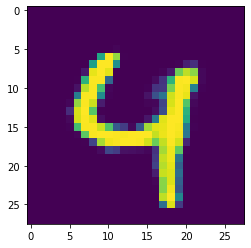

In [95]:
sample = images[2, :, :, 0]
plt.imshow(sample)

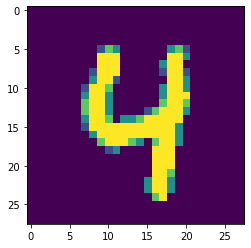

In [101]:
plt.imshow(comparison[0][0][194,:,:])

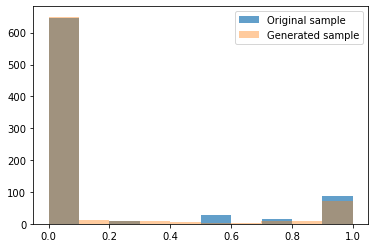

In [96]:
comp_sample = comparison[0][0][194,:,:]/255

plot_ht = plt.hist(comp_sample.reshape(28*28), bins=10, label="Original sample", alpha=0.7)
plot_ht_2 = plt.hist(sample.reshape(28*28), bins=10, label="Generated sample", alpha=0.4)
plt.legend()

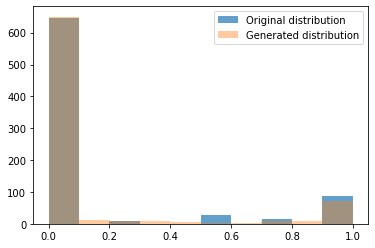

In [97]:
import sys
sys.path.append('../')
from helpers import *

plot_ht = plt.hist(comp_sample.reshape(28*28), alpha=0.7, label="Original distribution")
plot_ht_2 = plt.hist(sample.reshape(28*28), alpha=0.4, label="Generated distribution")
plt.legend()

new_x = align_hist(plot_ht, plot_ht_2, 10)

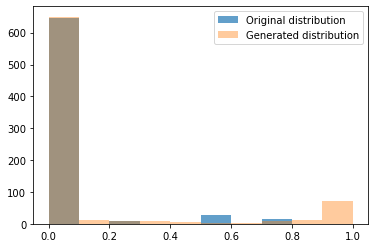

In [98]:
plot_ht = plt.hist(comp_sample.reshape(28*28), bins=new_x, alpha=0.7, label="Original distribution")
plot_ht_2 = plt.hist(sample.reshape(28*28), bins=new_x, alpha=0.4, label="Generated distribution")
plt.legend()

new_new_x = norm_hist(plot_ht[0], new_x)

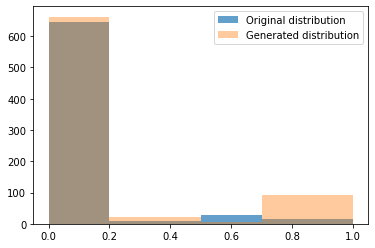

In [99]:
plot_ht = plt.hist(comp_sample.reshape(28*28), bins=new_new_x, alpha=0.7, label="Original distribution")
plot_ht_2 = plt.hist(sample.reshape(28*28), bins=new_new_x, alpha=0.4, label="Generated distribution")
plt.legend()

In [100]:
h1 = plot_ht[0]; h2 = plot_ht_2[0]

chi_squared(h1, h2)

435.2110996445362